In [434]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../host/')
from tqdm.notebook import tqdm

import ali_offline_demod as dm
from scipy.signal import find_peaks, periodogram
from scipy.fft import fft, fftfreq, fftshift, rfft

In [67]:
%matplotlib qt

In [404]:
def get_theta(I,Q):
        deltaQ = Q - np.mean(Q)
        deltaI = I - np.mean(I)
        
        alpha = np.mean(deltaQ * deltaI) / np.mean(deltaI * deltaI)
        
        theta = np.arctan(alpha)
    
        return theta, alpha

def rotate_ts_IQ(datafile):
        t, I, Q = dm.read_data(datafile)
        t_override = np.linspace(0,t[0],len(I[0])) #temporary override of t vector because of data bunching issue
        
        theta_array = np.array([])
        alpha_array = np.array([])
        for i in range(len(I)):
            theta, alpha = get_theta(I[i], Q[i])
            #print(theta)
            theta_array = np.append(theta_array, theta)
            alpha_array = np.append(alpha_array, alpha)
            
        #rotated_array = np.empty(np.shape(I[0]))

        rotated_array = np.array([(I[i] + 1j*Q[i]) * np.exp(-1j*(theta_array[i] + np.pi/4)) if theta_array[i] > 0 and alpha_array[i] > 0 else \
                            (I[i] + 1j*Q[i]) * np.exp(-1j*(theta_array[i] + np.pi/4 + np.pi/2)) if theta_array[i] > 0 and alpha_array[i] < 0 else \
                            (I[i] + 1j*Q[i]) * np.exp(-1j*(theta_array[i] - np.pi/4)) if theta_array[i] < 0 and alpha_array[i] > 0 else \
                            (I[i] + 1j*Q[i]) * np.exp(-1j*(theta_array[i] - np.pi/4 + np.pi/2)) if theta_array[i] < 0 and alpha_array[i] < 0 else \
                            (I[i] + 1j*Q[i]) for i in range(len(theta_array))])

        """
        for i in range(len(theta_array)):
            if theta_array[i] > 0:
                #print('>')
                if alpha_array[i] > 0:
                    rotated = (I[i] + 1j*Q[i]) * np.exp(-1j*(theta_array[i] + np.pi/4))
                else:
                    rotated = (I[i] + 1j*Q[i]) * np.exp(-1j*(theta_array[i] + np.pi/4 + np.pi/2))
            elif theta_array[i] < 0:
                #print('<')
                if alpha_array[i] > 0:
                    rotated = (I[i] + 1j*Q[i]) * np.exp(-1j*(theta_array[i] - np.pi/4))
                else:
                    rotated = (I[i] + 1j*Q[i]) * np.exp(-1j*(theta_array[i] - np.pi/4 + np.pi/2))
            else:
                rotated = (I[i] + 1j*Q[i])
        
            rotated_array = np.vstack([rotated_array, rotated])
        """
        
        #print(rotated_array)
        
        I_rotated = np.real(rotated_array)
        Q_rotated = np.imag(rotated_array)
        
           
        theta_2_array = np.array([])
        alpha_2_array = np.array([])
        for i in range(len(I)):
            theta, alpha = get_theta(I_rotated[i], Q_rotated[i])
            #print(theta)
            theta_2_array = np.append(theta_2_array, theta)
            alpha_2_array = np.append(alpha_2_array, alpha)
        
        
        rotated_2_array = np.array([(I_rotated[i] + 1j*Q_rotated[i]) * np.exp(-1j*(theta_2_array[i] + np.pi/4)) if theta_2_array[i] > 0 and alpha_2_array[i] > 0 else \
                                 (I_rotated[i] + 1j*Q_rotated[i]) * np.exp(-1j*(theta_2_array[i] + np.pi/4 + np.pi/2)) if theta_2_array[i] > 0 and alpha_2_array[i] < 0 else \
                                 (I_rotated[i] + 1j*Q_rotated[i]) * np.exp(-1j*(theta_2_array[i] - np.pi/4)) if theta_2_array[i] < 0 and alpha_2_array[i] > 0 else \
                                 (I_rotated[i] + 1j*Q_rotated[i]) * np.exp(-1j*(theta_2_array[i] - np.pi/4 + np.pi/2)) if theta_2_array[i] < 0 and alpha_2_array[i] < 0 else \
                                 (I_rotated[i] + 1j*Q_rotated[i]) for i in range(len(theta_2_array))])

        """
        rotated_2_array = np.empty(np.shape(I[0]))
        
        for i in range(len(theta_array)):
            if theta_2_array[i] > 0:
                #print('>')
                if alpha_2_array[i] > 0:
                    rotated = (I_rotated[i] + 1j*Q_rotated[i]) * np.exp(-1j*(theta_2_array[i] + np.pi/4))
                else:
                    rotated = (I_rotated[i] + 1j*Q_rotated[i]) * np.exp(-1j*(theta_2_array[i] + np.pi/4 + np.pi/2))
            elif theta_2_array[i] < 0:
                #print('<')
                if alpha_2_array[i] > 0:
                    rotated = (I_rotated[i] + 1j*Q_rotated[i]) * np.exp(-1j*(theta_2_array[i] - np.pi/4))
                else:
                    rotated = (I_rotated[i] + 1j*Q_rotated[i]) * np.exp(-1j*(theta_2_array[i] - np.pi/4 + np.pi/2))
            else:
                rotated = (I_rotated[i] + 1j*Q_rotated[i])
        
            rotated_2_array = np.vstack([rotated_2_array, rotated])
        """
        I_rotated_2 = np.real(rotated_2_array)
        Q_rotated_2 = np.imag(rotated_2_array)
        
        return t_override, I_rotated_2, Q_rotated_2

In [19]:
datapath = 'C:\\Users\\mowit\\OneDrive\\Documents\\temp_data\\data_at_asu'

In [90]:
# Data without Magnet Modulation

t, I, Q = dm.read_data(f'{datapath}\\time_streams\\ts_toneinit_fcenter_5050.0_20250205125710_t_20250205130812.hd5')
Z = I + 1j*Q
t_override = np.linspace(0,10,len(I[0]))

In [110]:
# Plotting Individual Channels

ch = 20

fig, ax = plt.subplots(1)

ax.plot(t_override, np.abs(Z[ch]) - np.average(np.abs(Z[ch])),'.-')
ax.set_title(f'No Modulation; Demoded with Demod LUT; Ch = {ch}')
ax.set_xlabel('t (s)')
ax.set_ylabel('|Z| - <|Z|> (arb.)')
ax.set_ylim([-1500,1500])

(-1500.0, 1500.0)

In [25]:
# Data with Magnet Modulation

t_mag, I_mag, Q_mag = dm.read_data(f'{datapath}\\time_streams\\ts_toneinit_fcenter_5050.0_20250205125710_t_20250205134813.hd5')
Z_mag = I_mag + 1j*Q_mag
t_mag_override = np.linspace(0,10,len(I_mag[0]))


In [112]:
# Plotting Individual Channels

ch = 20

fig, ax = plt.subplots(1)

ax.plot(t_mag_override, np.abs(Z_mag[ch]) - np.average(np.abs(Z_mag[ch])),'.-')
ax.set_title(f'Modulation with Magnet; Demoded with Demod LUT; Ch = {ch}')
ax.set_xlabel('t (s)')
ax.set_ylabel('|Z| - <|Z|> (arb.)')
ax.set_ylim([-1500,1500])

(-1500.0, 1500.0)

In [83]:
# Plotting All Channels

fig, ax = plt.subplots(1)
for ch in range(len(Z_mag)):
    ax.plot(t_mag_override, np.abs(Z_mag[ch]) - np.average(np.abs(Z_mag[ch])) + 1000*ch,'.-')


ax.set_title(f'Modulation with Magnet; Demoded with Demod LUT', fontsize=30)
ax.set_xlabel('t (s)',fontsize=30)
ax.set_ylabel('|Z| - <|Z|> (arb.)',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30)

ax.set_ylim([-1000,5000])

(-1000.0, 5000.0)

C:\Users\mowit\AppData\Local\Temp\ipykernel_76196\1214363258.py:5: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.mean(deltaQ * deltaI) / np.mean(deltaI * deltaI)
C:\Users\mowit\AppData\Local\Temp\ipykernel_76196\4257223055.py:18: RuntimeWarning: invalid value encountered in divide
  Z_scaled = (np.abs(Z) - np.mean(np.abs(Z),axis=1)[:,np.newaxis]) / A[:,np.newaxis] * 1e6  / (2*np.pi) #A[:,np.newaxis(len(Z))]


  0%|          | 0/66 [00:00<?, ?it/s]

Ch 0 Noise                        = 2.69 +/- 1.90 μΦ_0/sqrt(Hz)
Ch 1 Noise                        = 4.03 +/- 4.06 μΦ_0/sqrt(Hz)
Ch 2 Noise                        = 473.41 +/- 725.66 μΦ_0/sqrt(Hz)
Ch 3 Noise                        = 3.54 +/- 5.21 μΦ_0/sqrt(Hz)
Ch 4 Noise                        = 3.11 +/- 2.96 μΦ_0/sqrt(Hz)
Ch 5 Noise                        = 3.91 +/- 3.93 μΦ_0/sqrt(Hz)
Ch 6 Noise                        = 3.42 +/- 3.84 μΦ_0/sqrt(Hz)


C:\Users\mowit\AppData\Local\Temp\ipykernel_76196\4257223055.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig3, ax3 = plt.subplots(1)


Ch 7 Noise                        = 3.41 +/- 4.32 μΦ_0/sqrt(Hz)
Ch 8 Noise                        = 4.18 +/- 4.23 μΦ_0/sqrt(Hz)
Ch 9 Noise                        = 2.92 +/- 2.80 μΦ_0/sqrt(Hz)
Ch 10 Noise                       = 2.86 +/- 2.71 μΦ_0/sqrt(Hz)
Ch 11 Noise                       = 4.46 +/- 4.38 μΦ_0/sqrt(Hz)
Ch 12 Noise                       = 4.62 +/- 5.35 μΦ_0/sqrt(Hz)
Ch 13 Noise                       = 4.32 +/- 4.07 μΦ_0/sqrt(Hz)
Ch 14 Noise                       = 4.35 +/- 4.81 μΦ_0/sqrt(Hz)
Ch 15 Noise                       = 9.14 +/- 9.84 μΦ_0/sqrt(Hz)
Ch 16 Noise                       = 3.35 +/- 3.00 μΦ_0/sqrt(Hz)
Ch 17 Noise                       = 12.28 +/- 11.45 μΦ_0/sqrt(Hz)
Ch 18 Noise                       = 4.67 +/- 4.41 μΦ_0/sqrt(Hz)
Ch 19 Noise                       = 4.61 +/- 4.46 μΦ_0/sqrt(Hz)
Ch 20 Noise                       = 7.45 +/- 6.08 μΦ_0/sqrt(Hz)
Ch 21 Noise                       = 7.93 +/- 9.45 μΦ_0/sqrt(Hz)
Ch 22 Noise                       = 4.

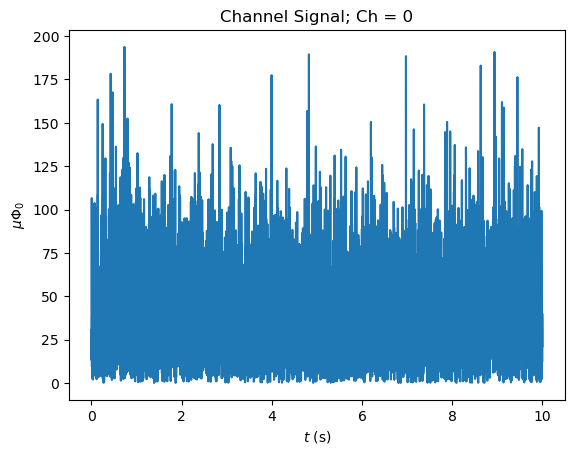

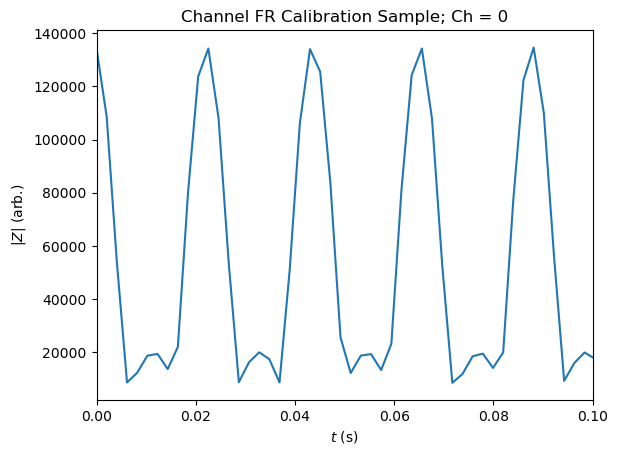

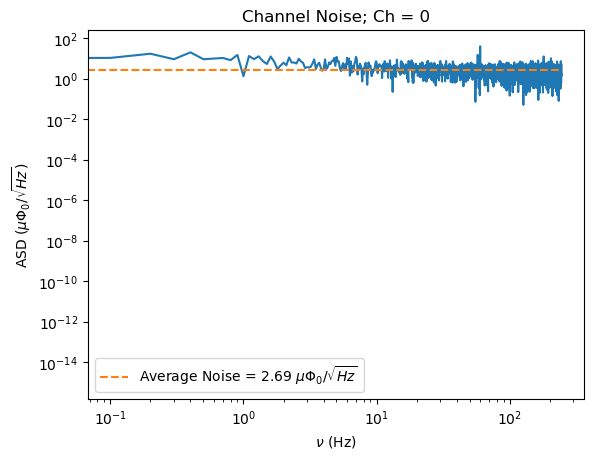

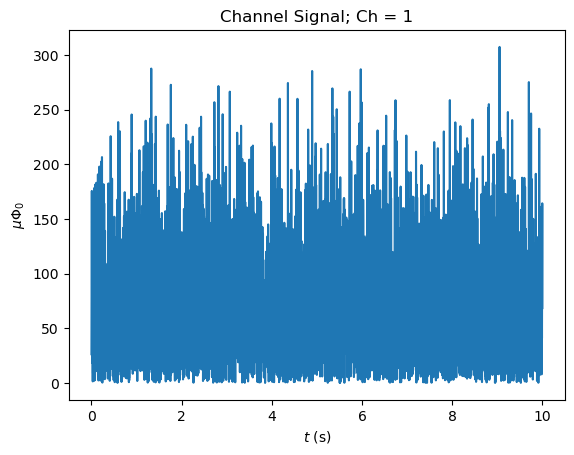

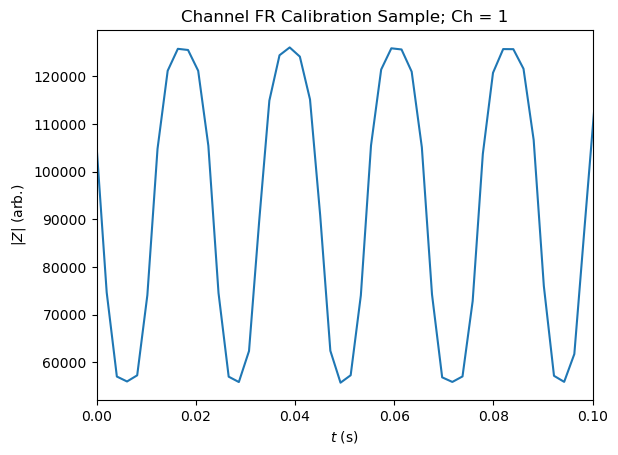

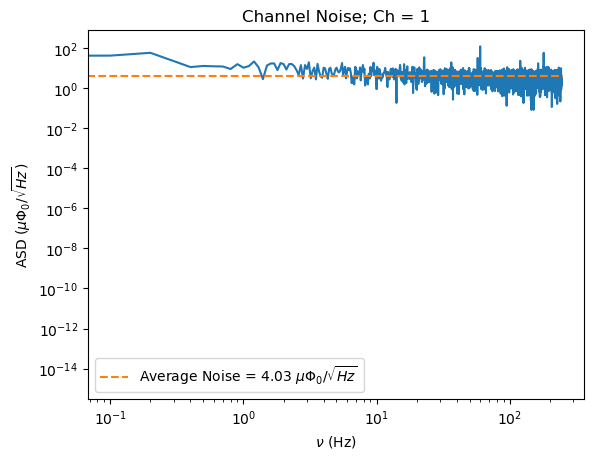

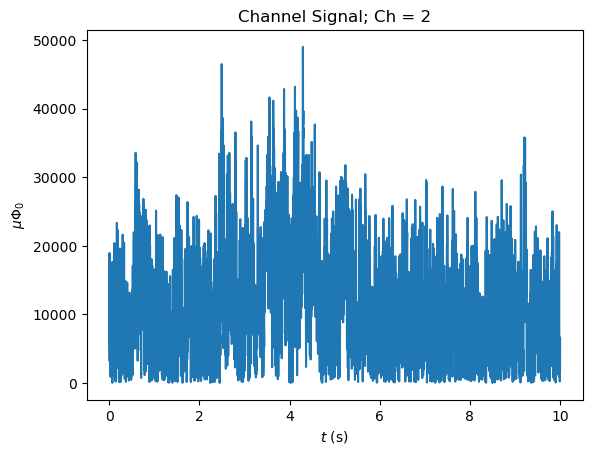

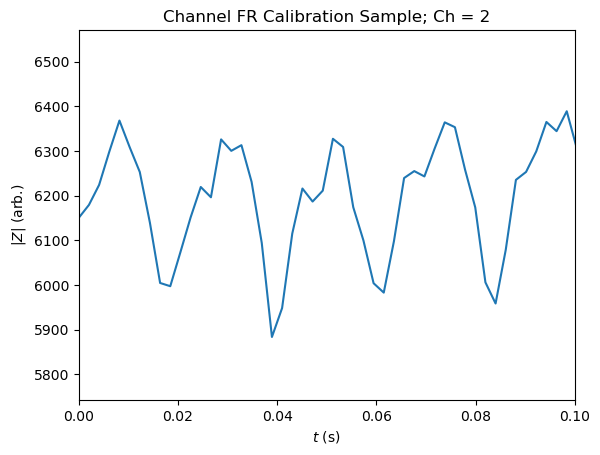

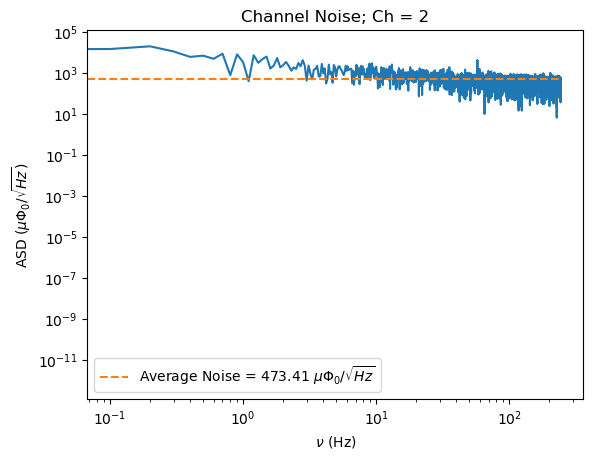

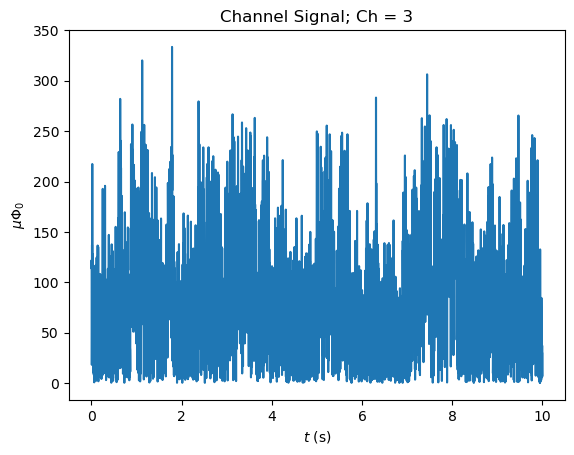

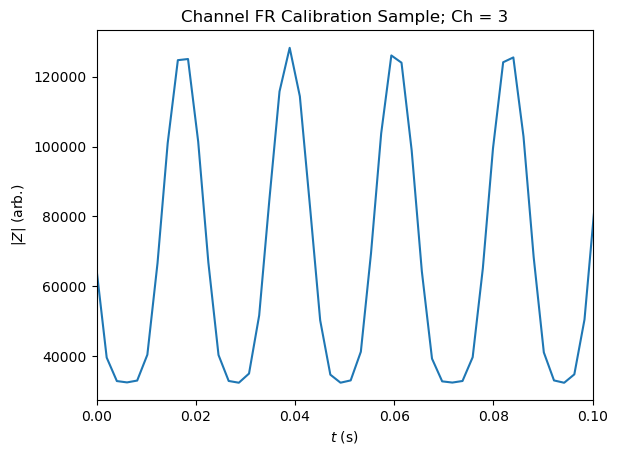

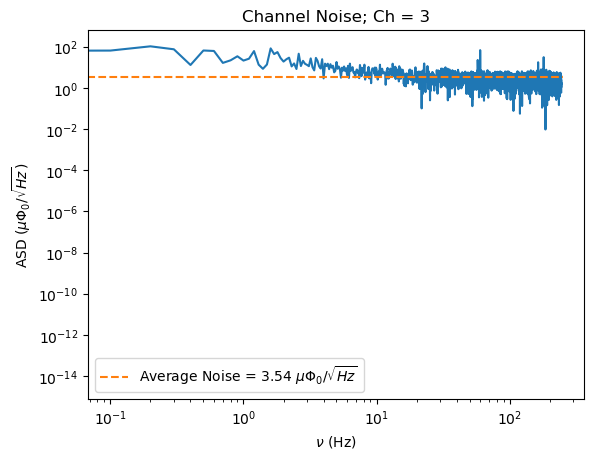

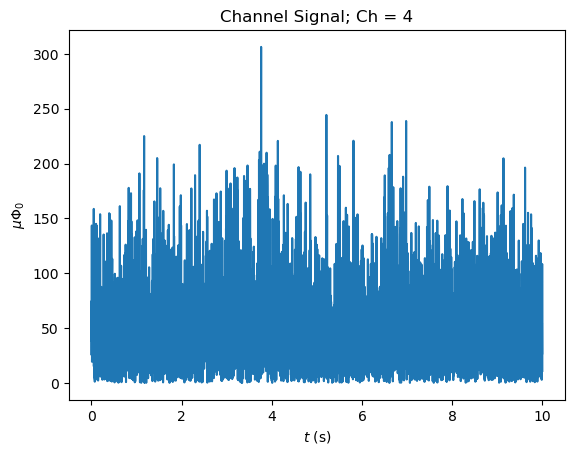

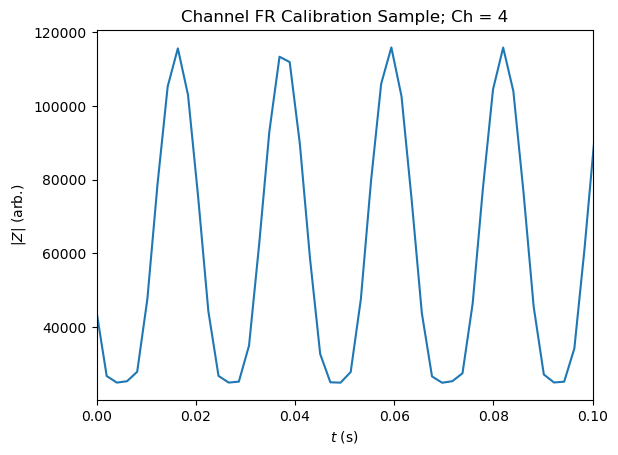

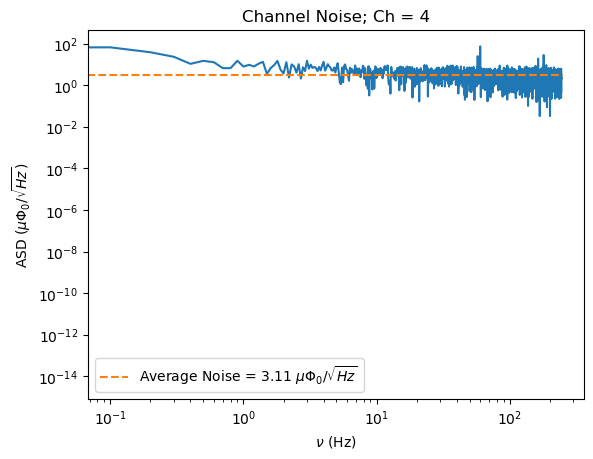

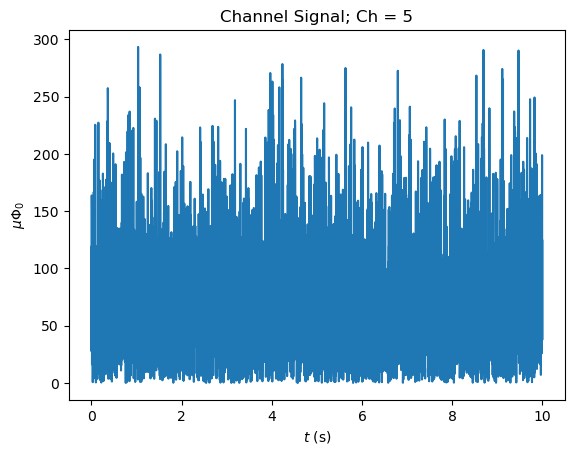

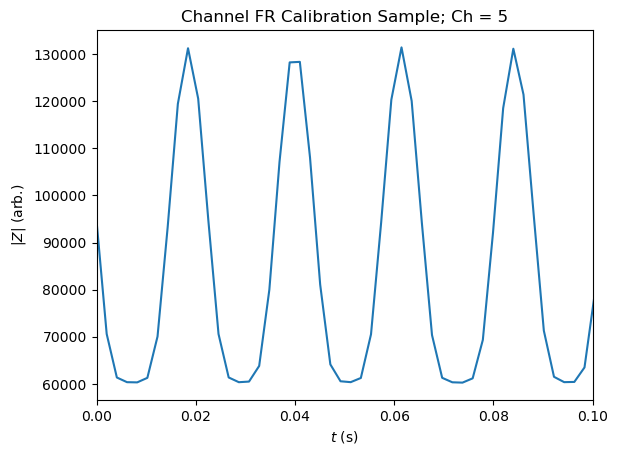

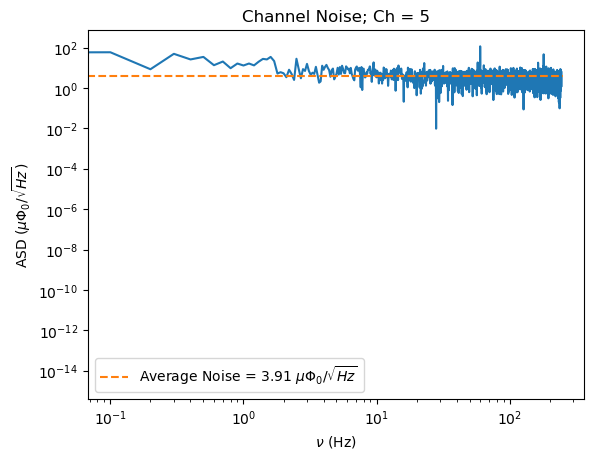

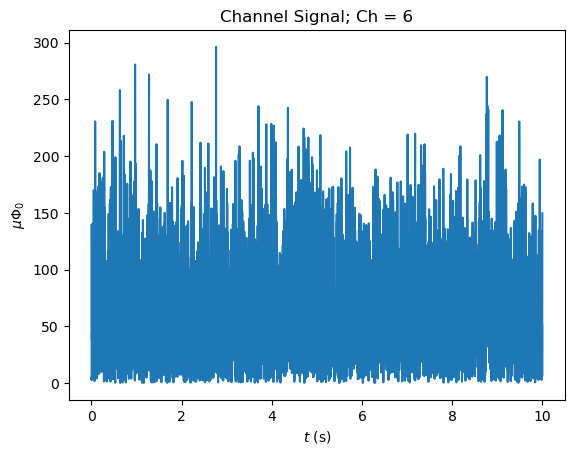

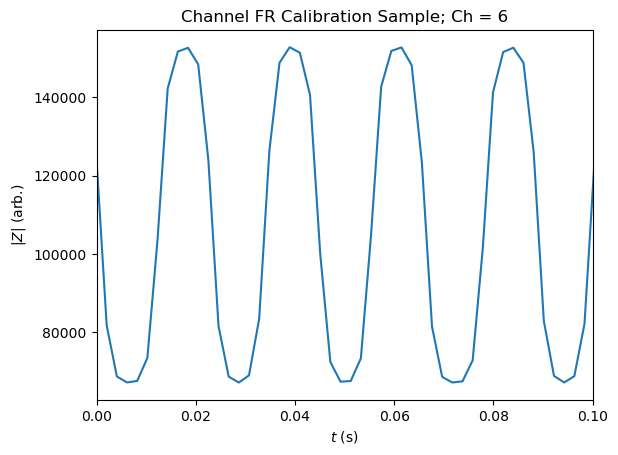

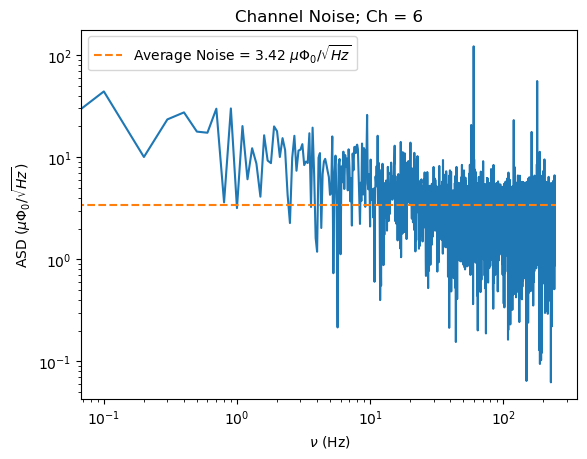

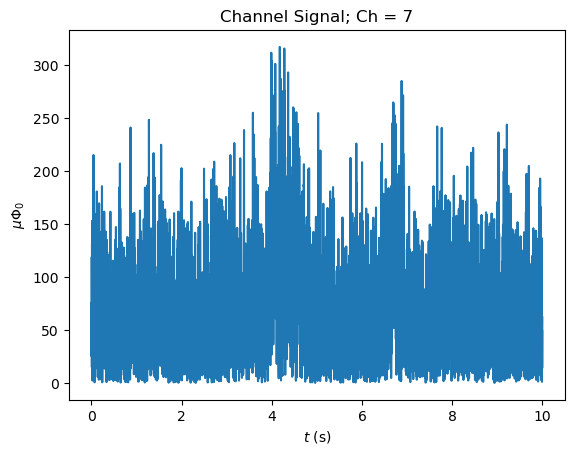

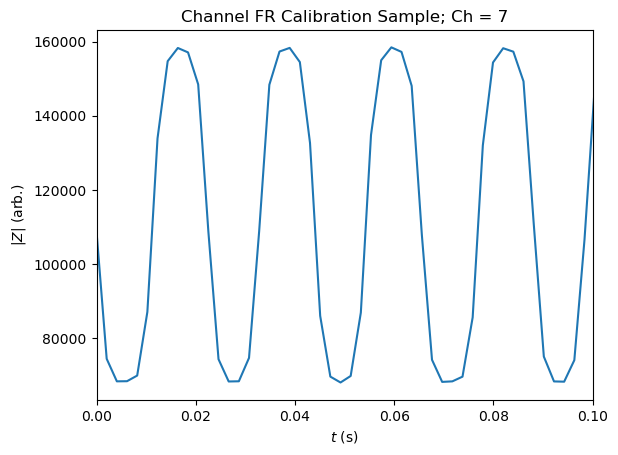

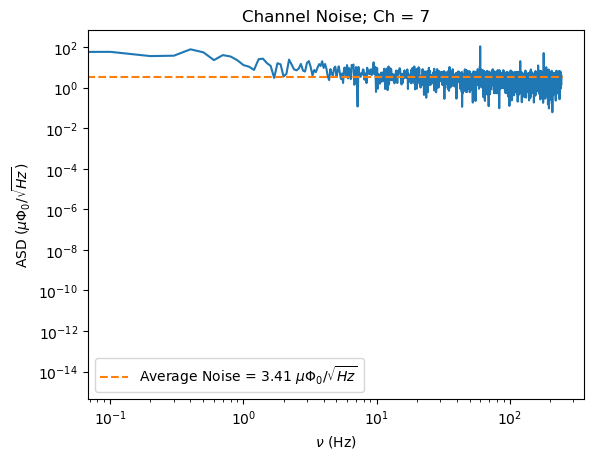

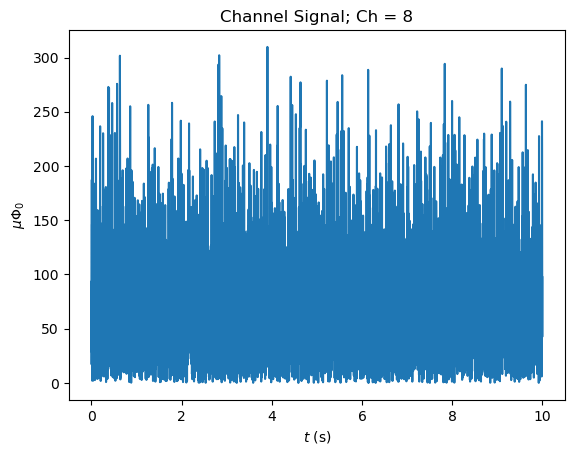

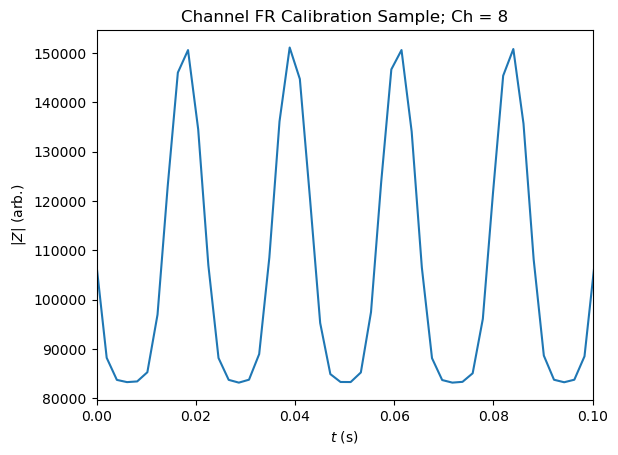

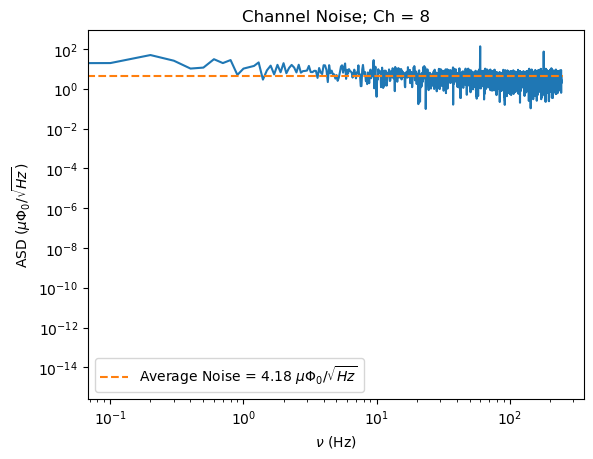

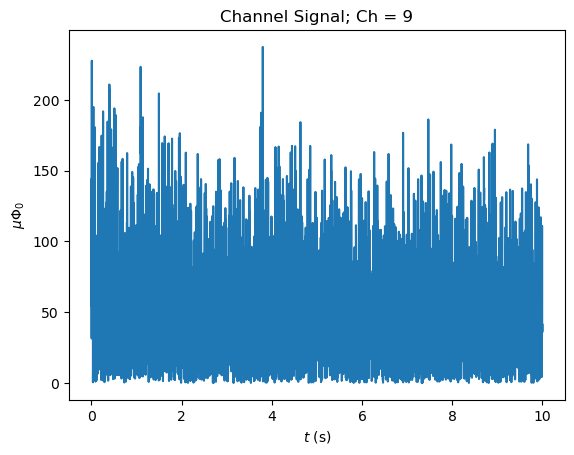

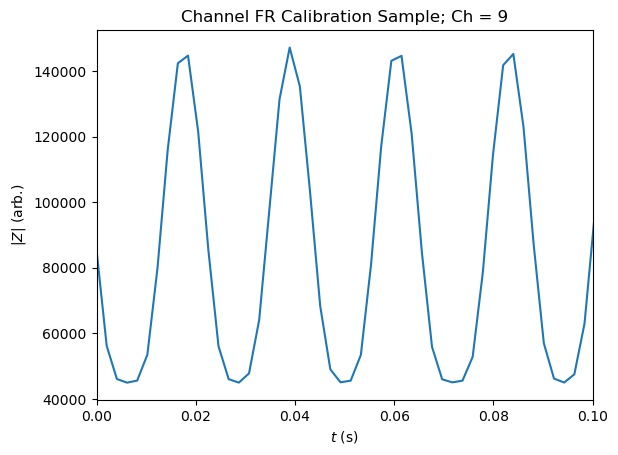

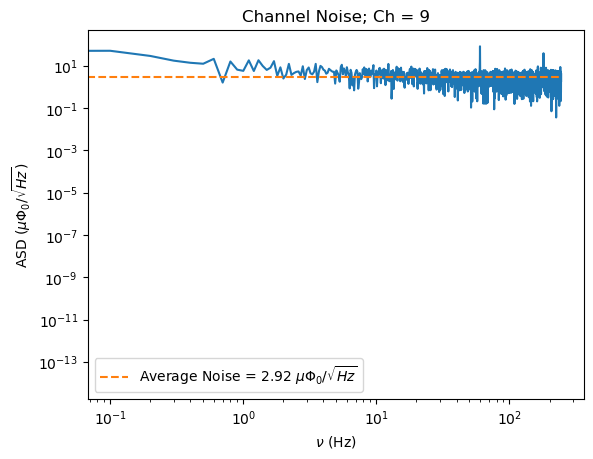

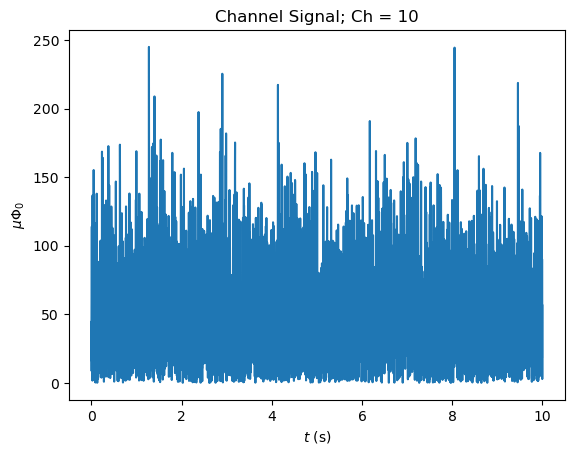

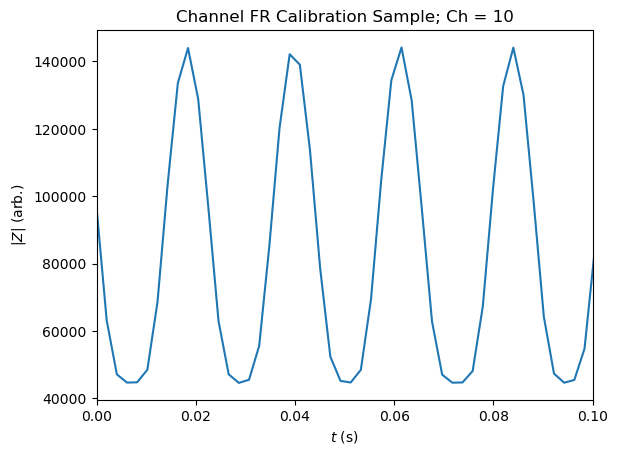

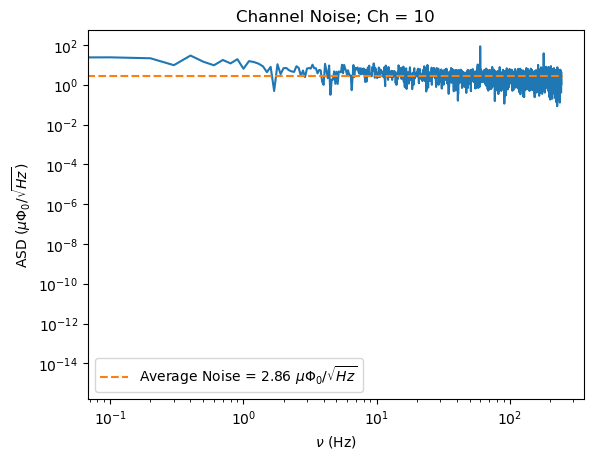

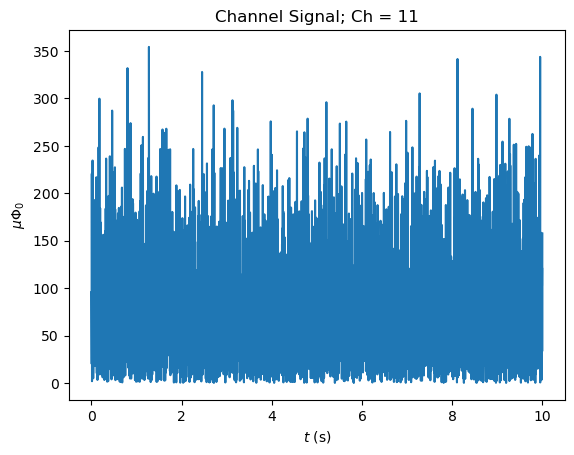

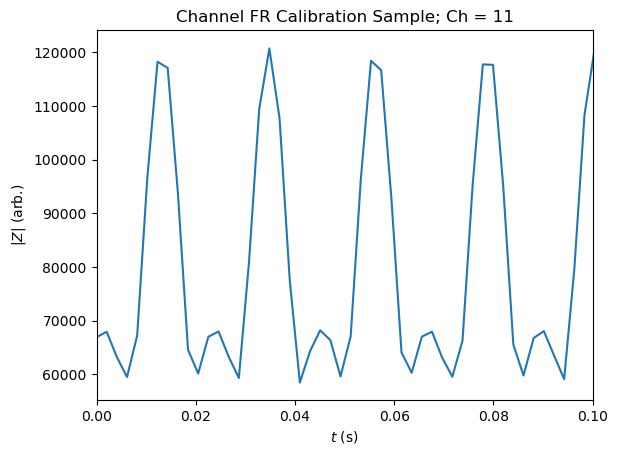

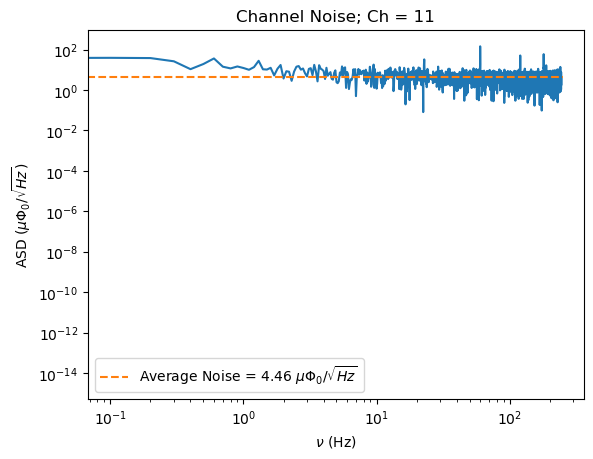

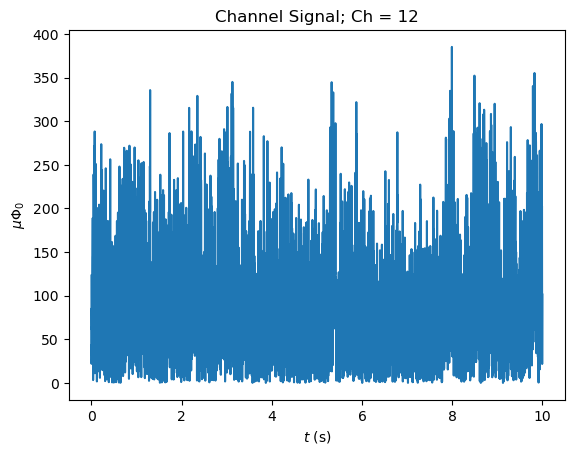

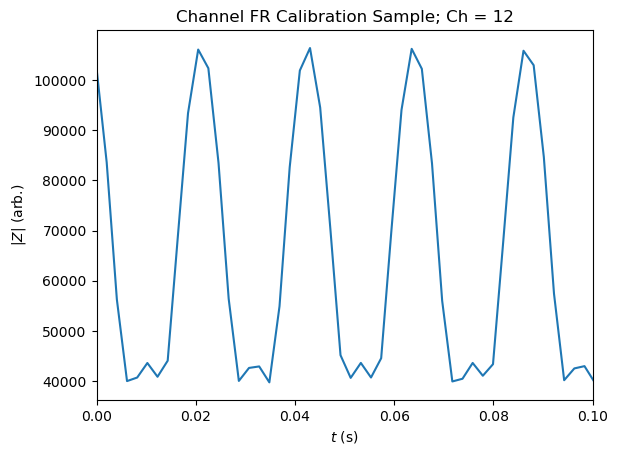

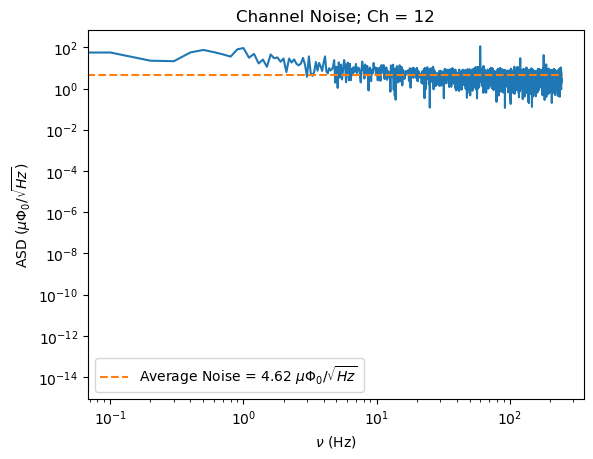

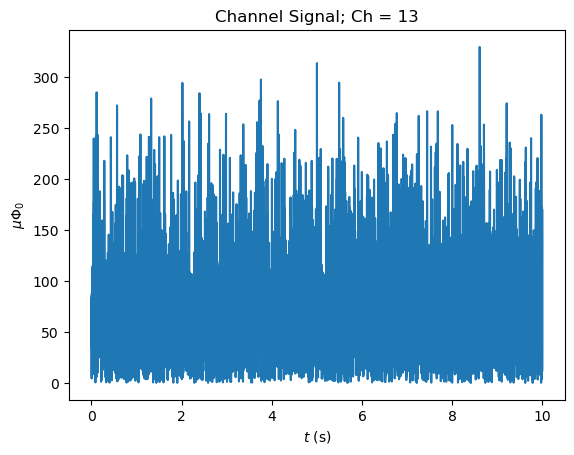

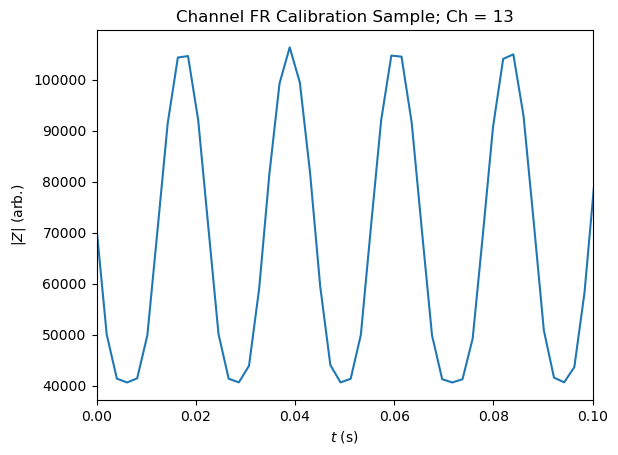

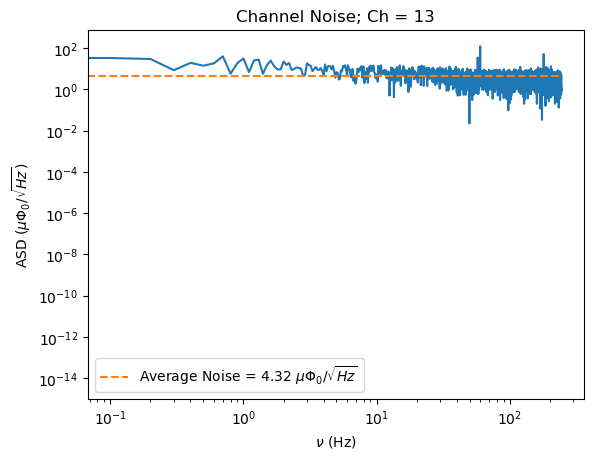

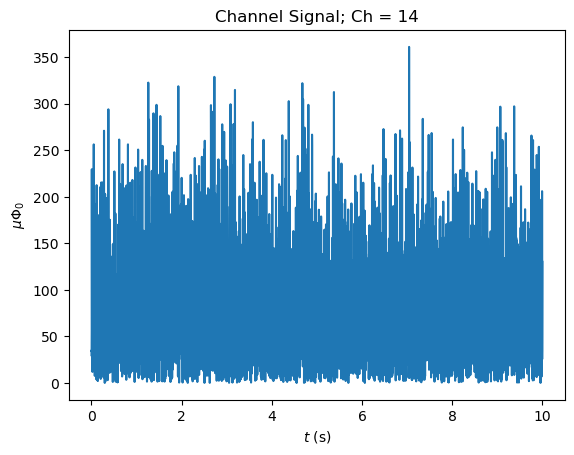

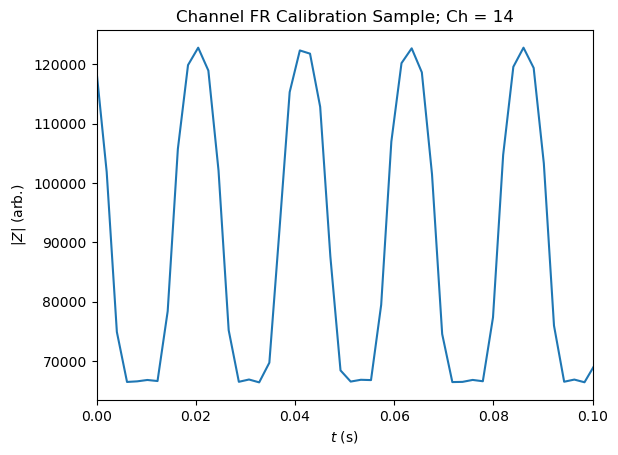

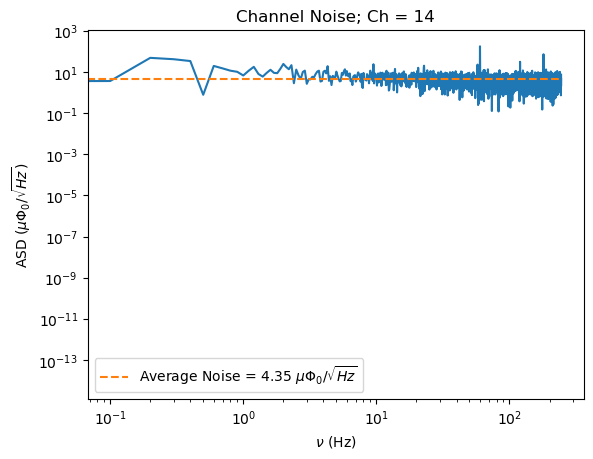

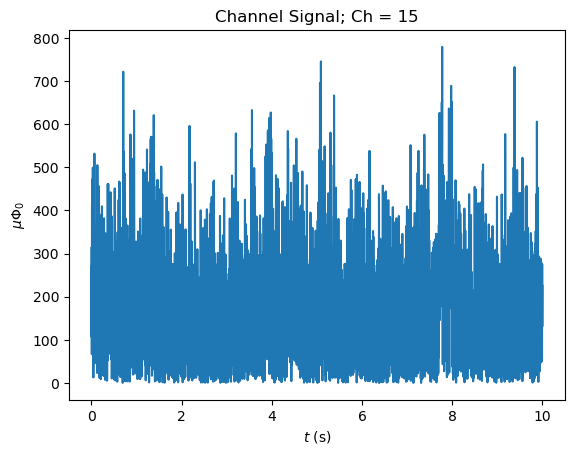

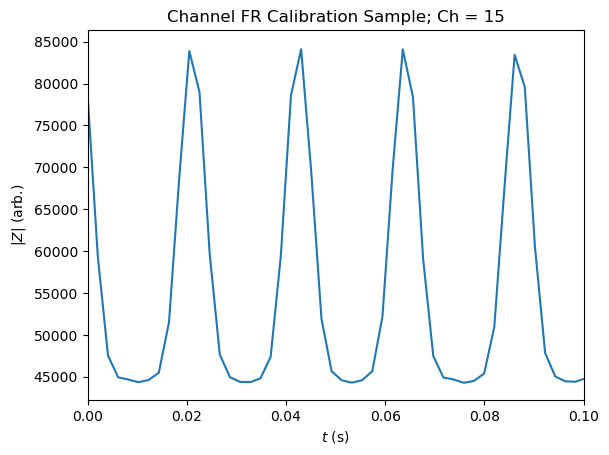

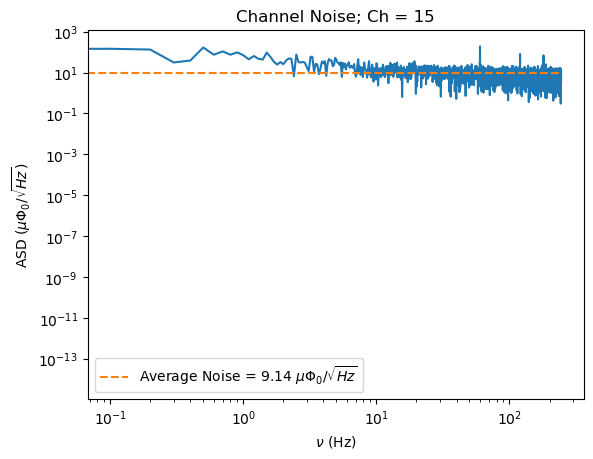

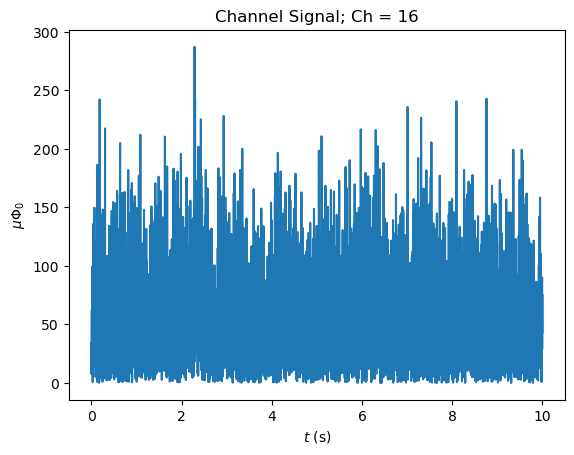

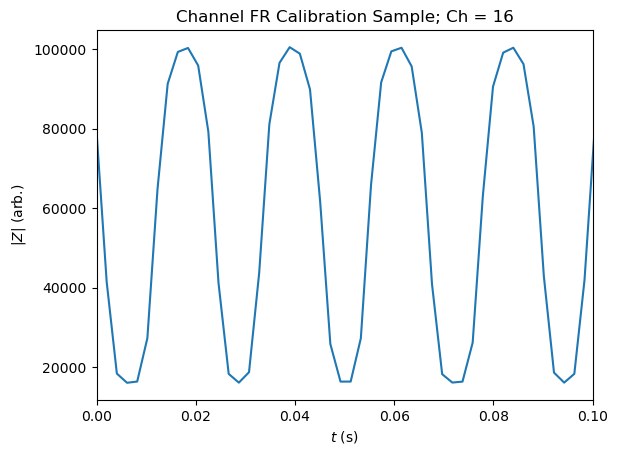

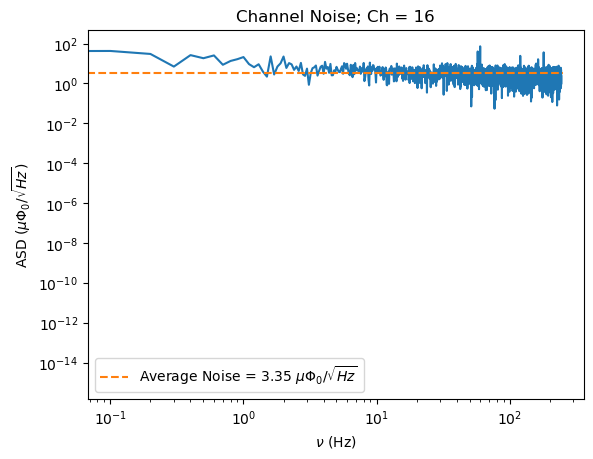

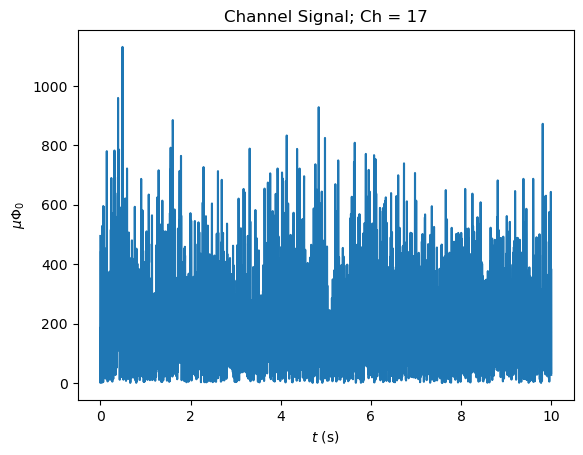

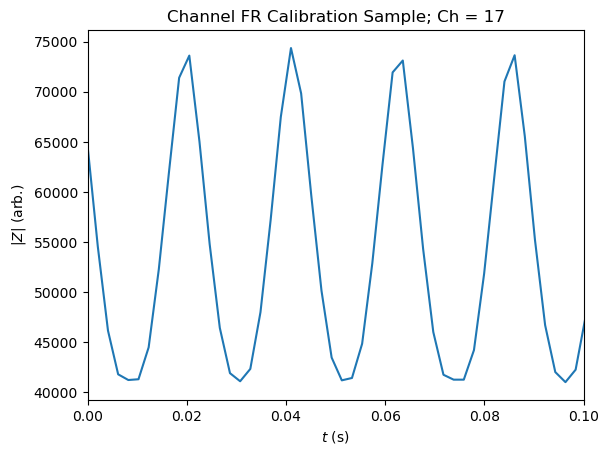

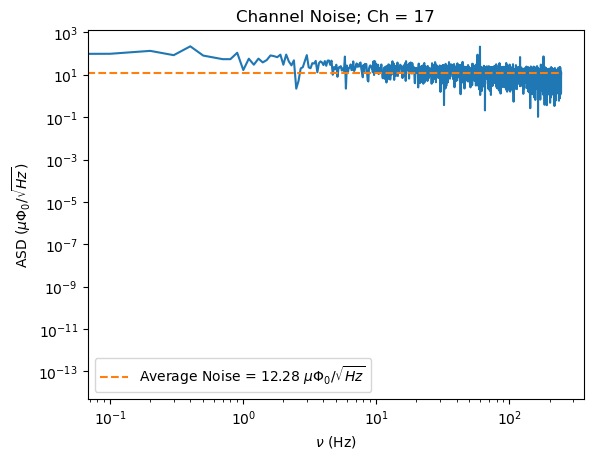

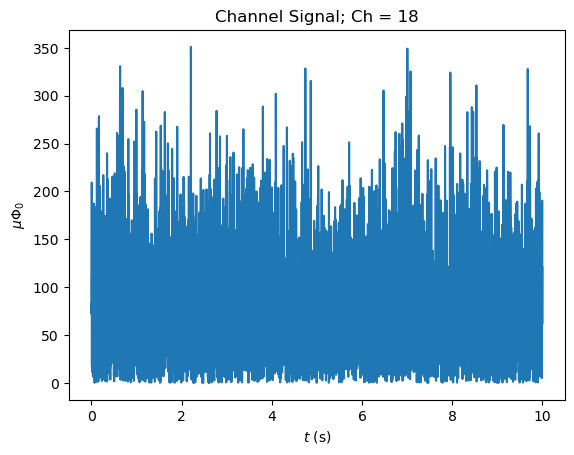

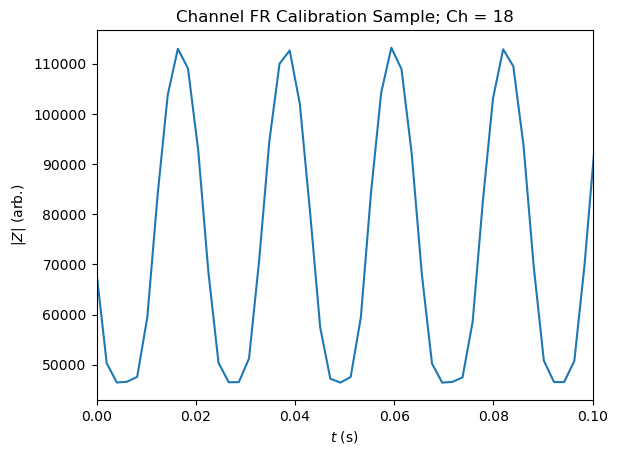

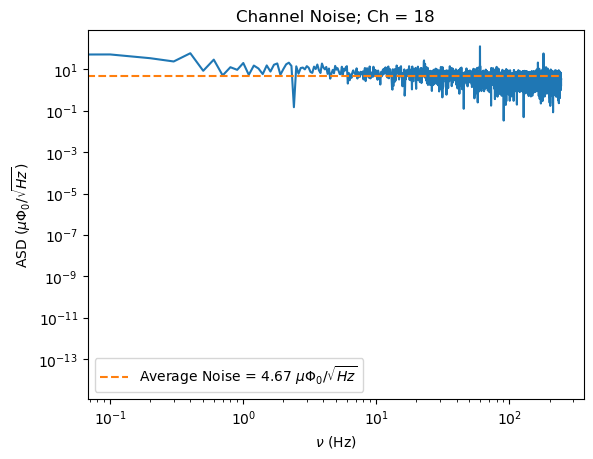

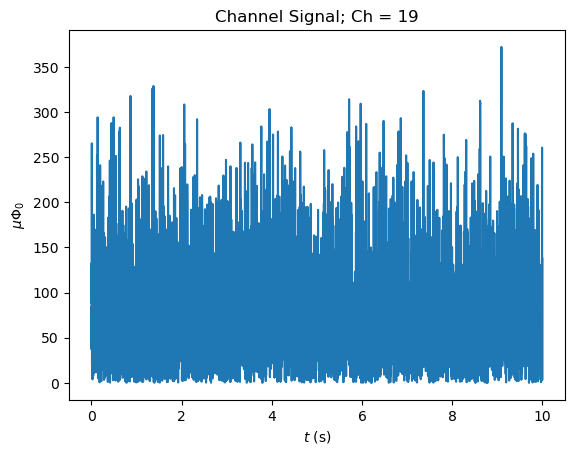

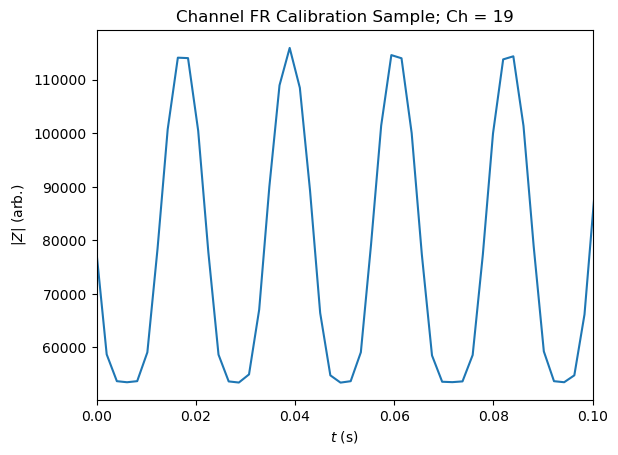

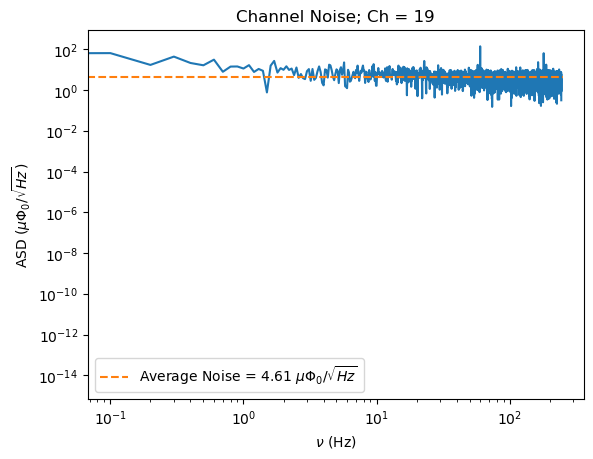

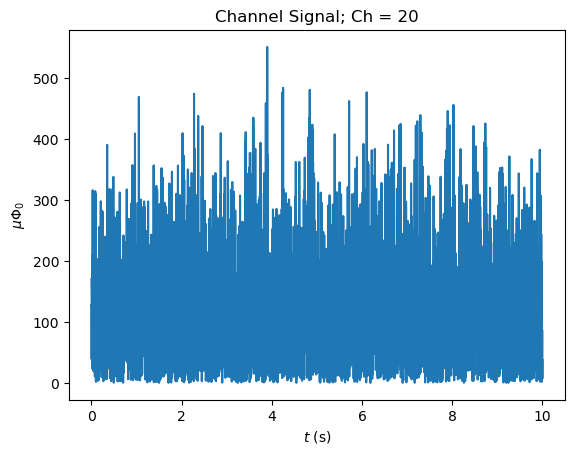

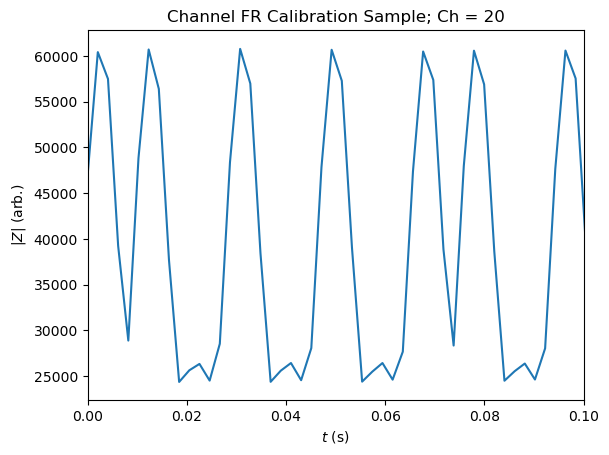

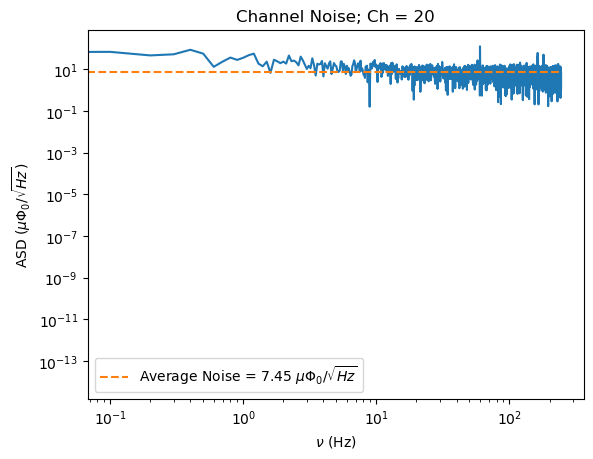

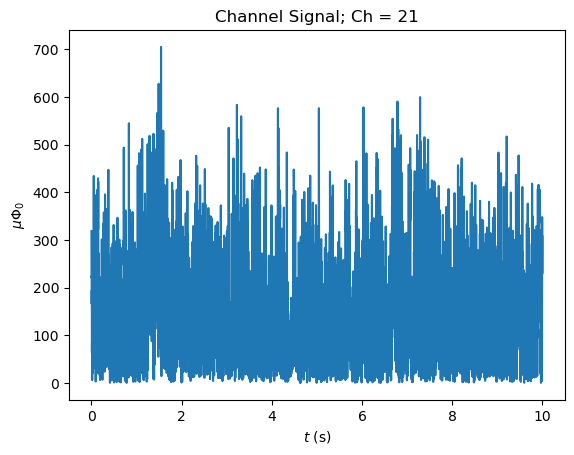

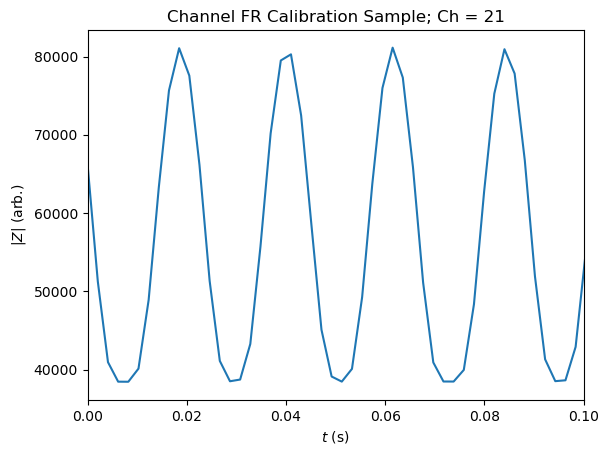

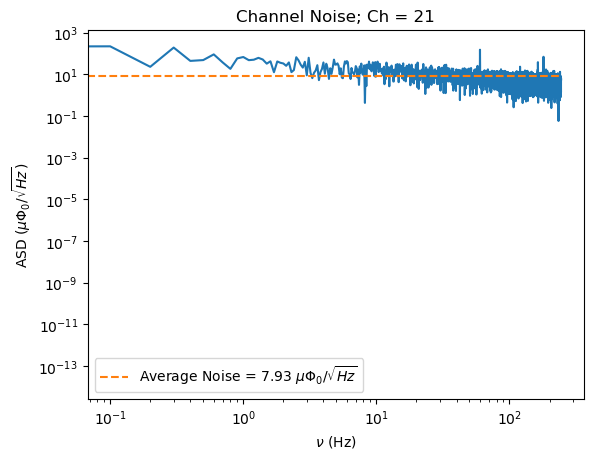

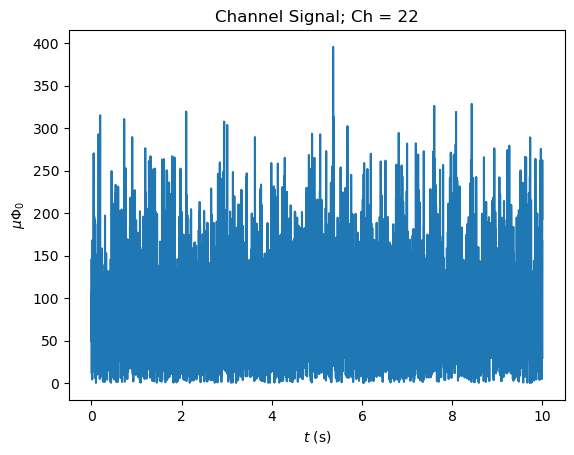

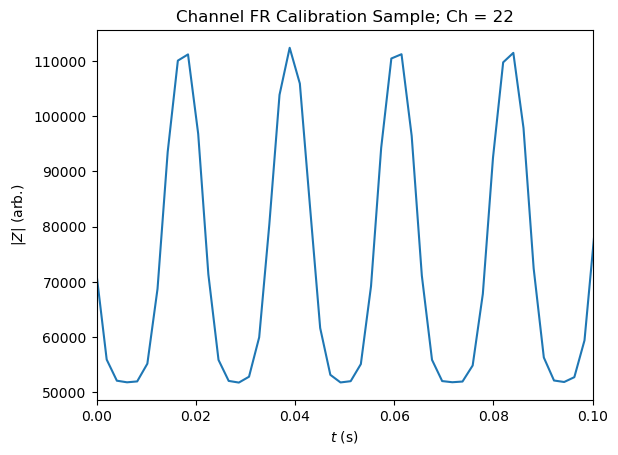

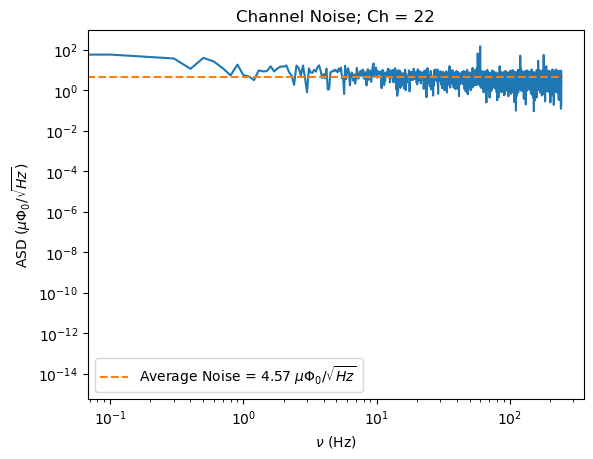

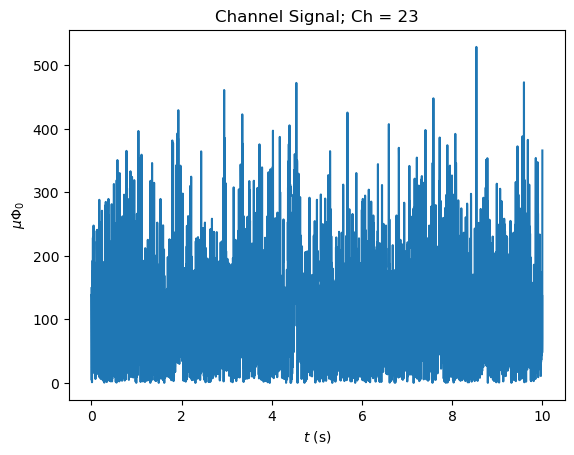

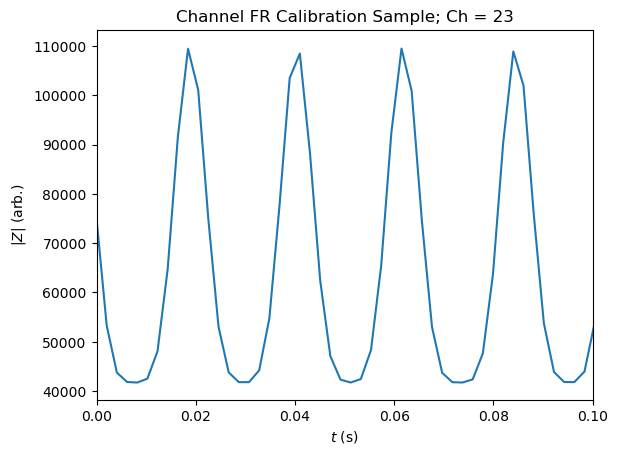

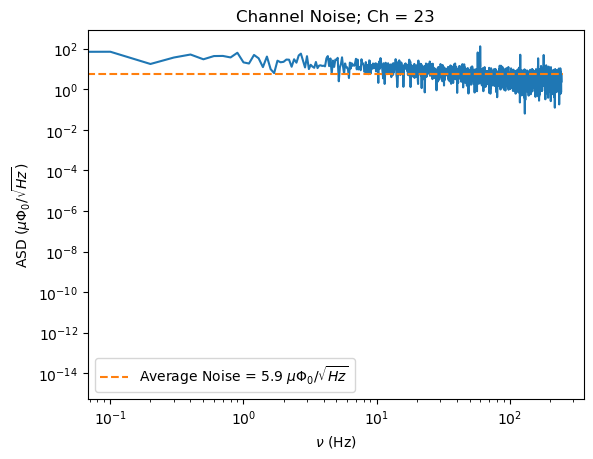

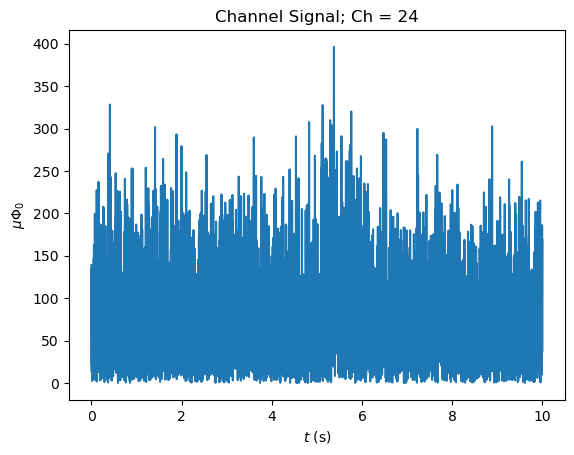

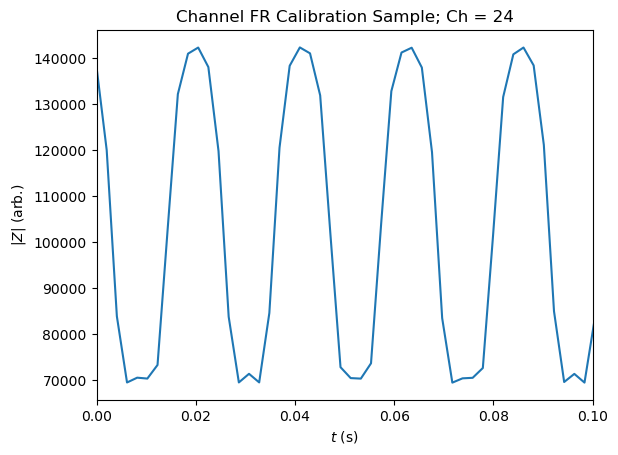

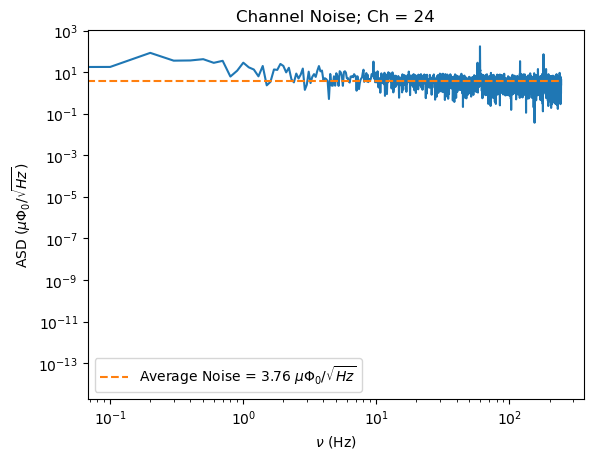

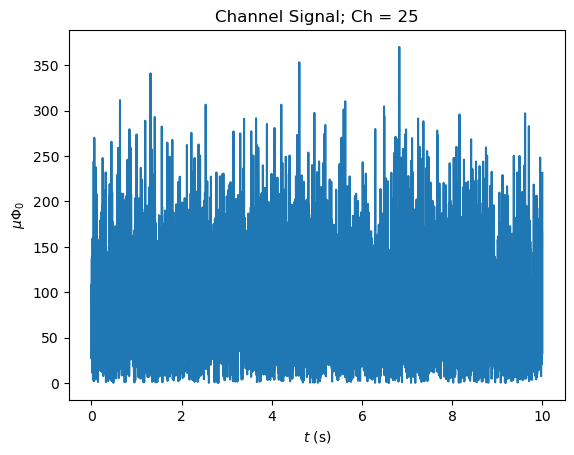

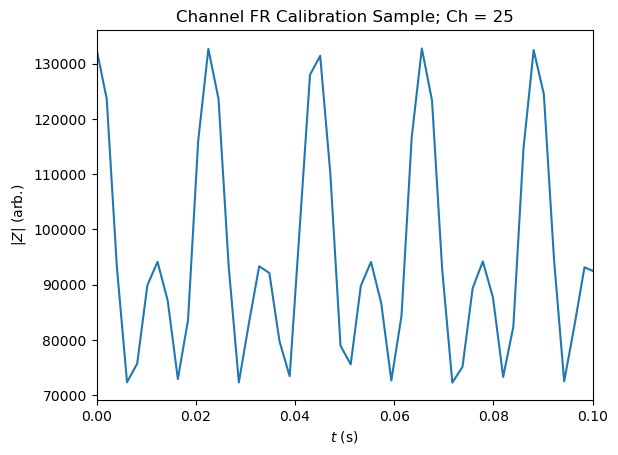

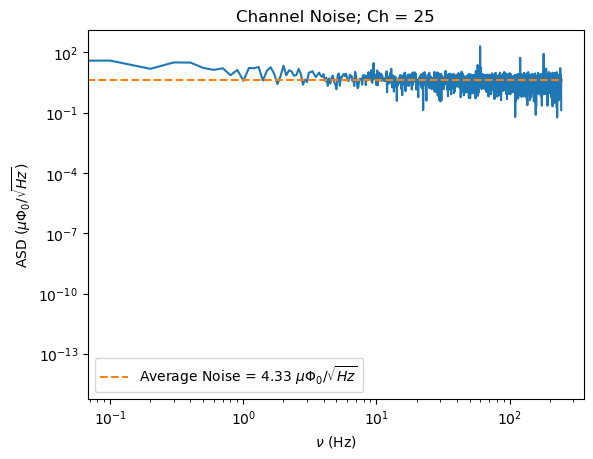

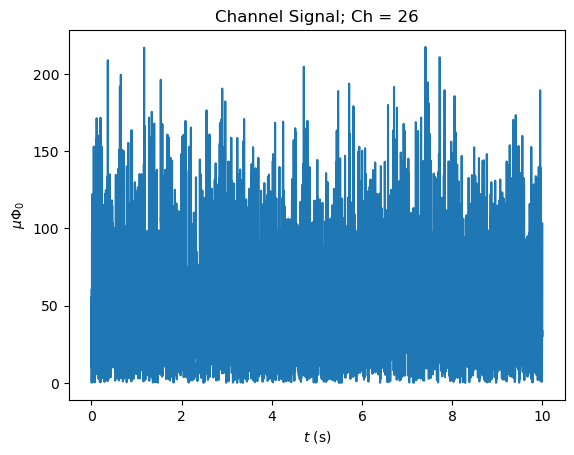

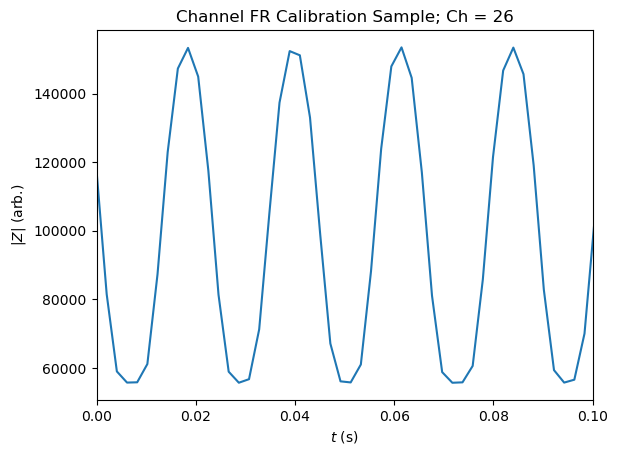

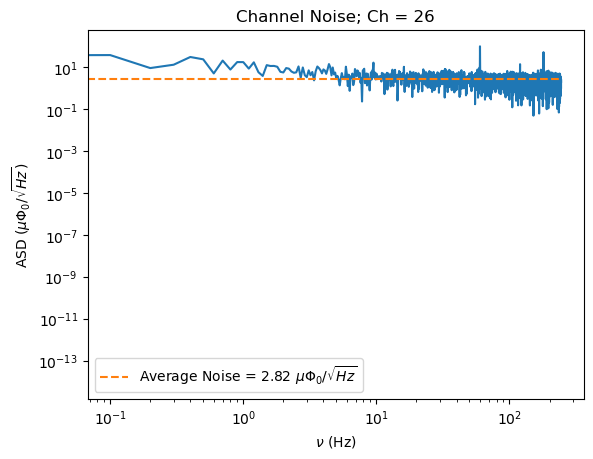

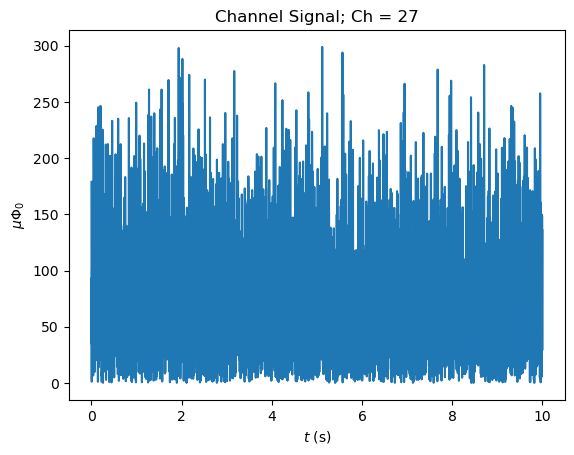

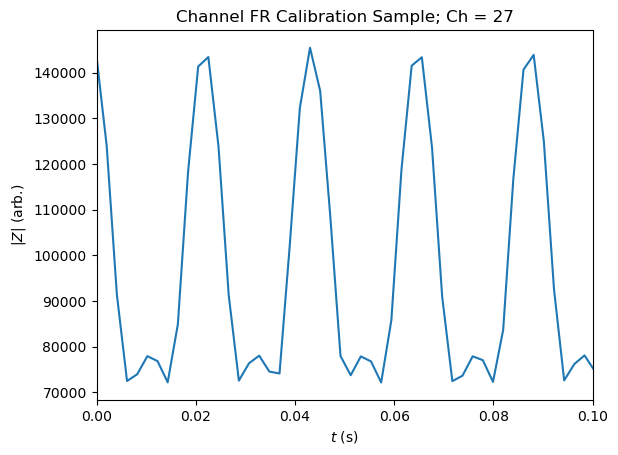

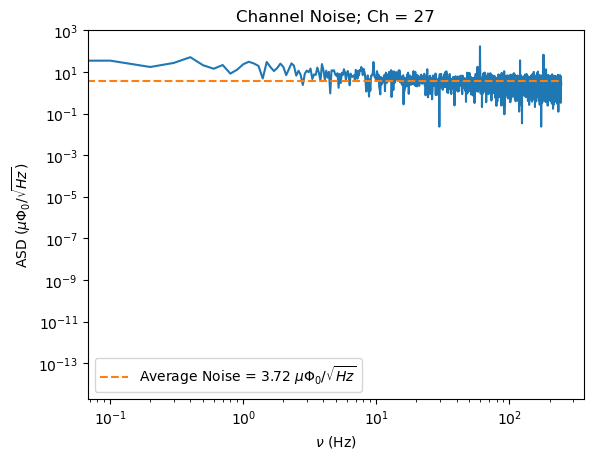

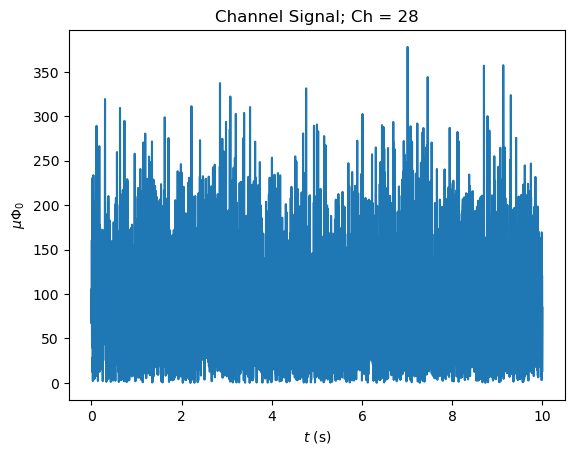

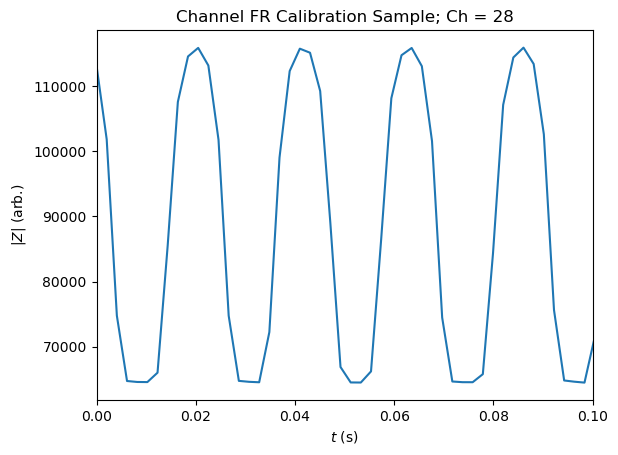

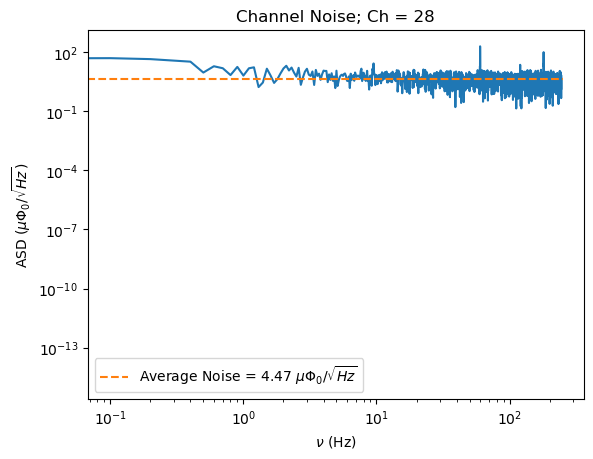

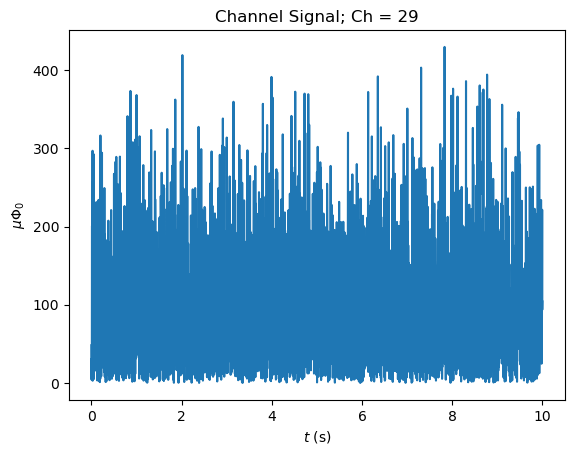

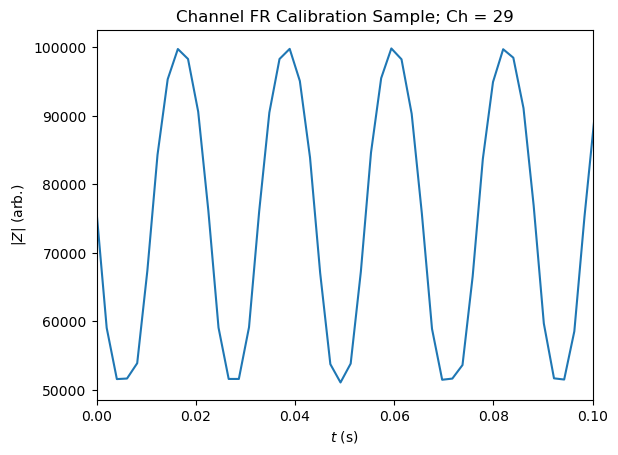

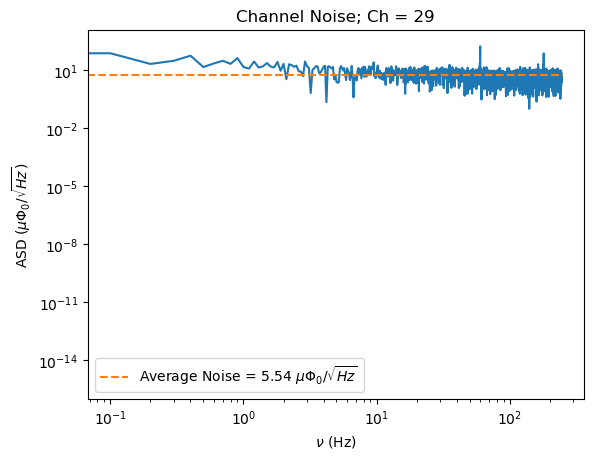

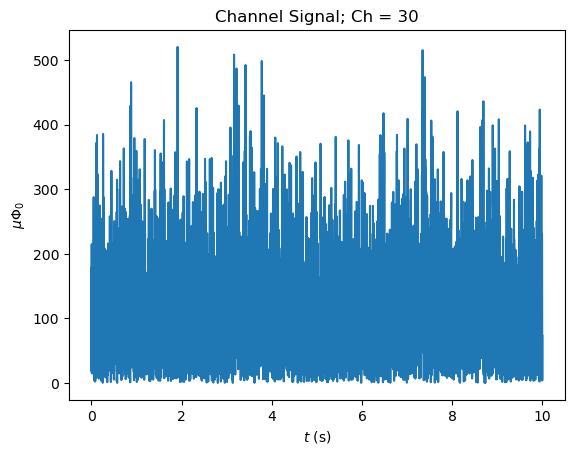

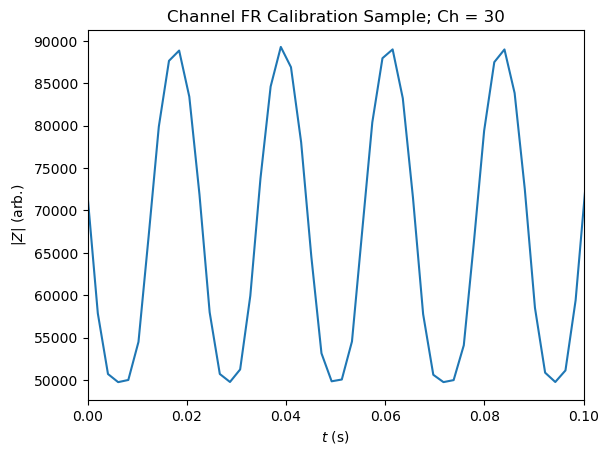

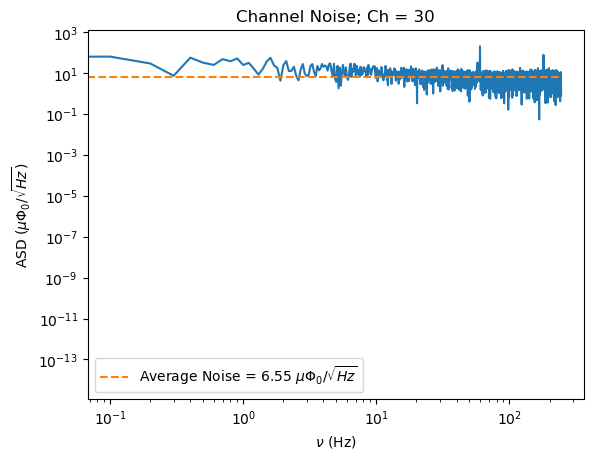

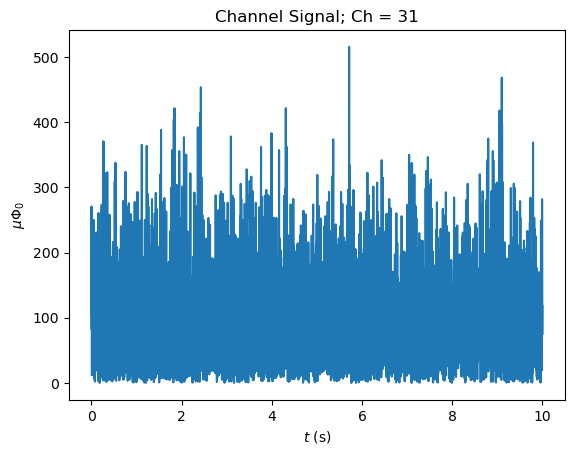

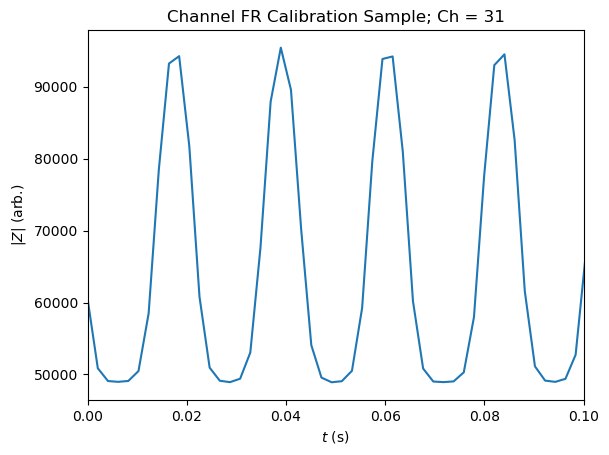

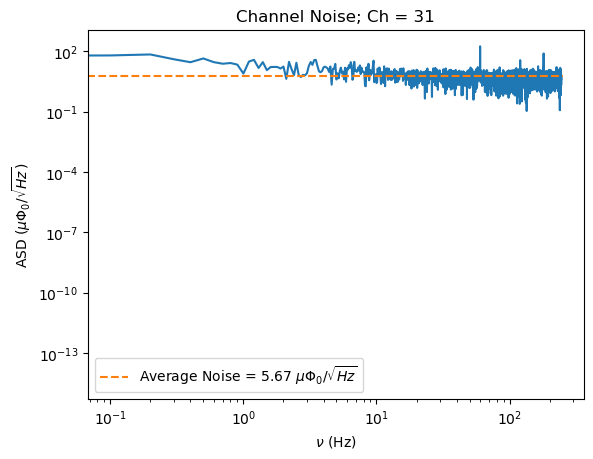

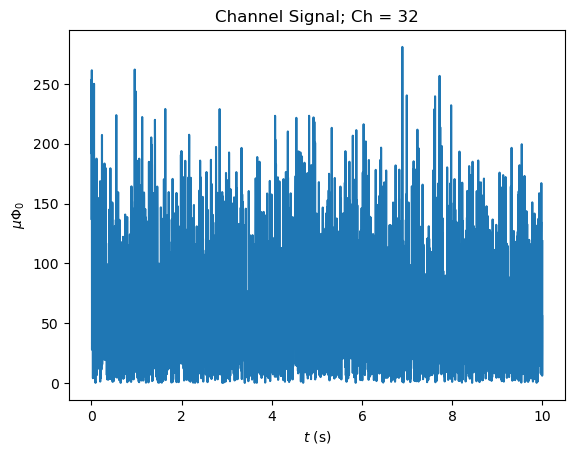

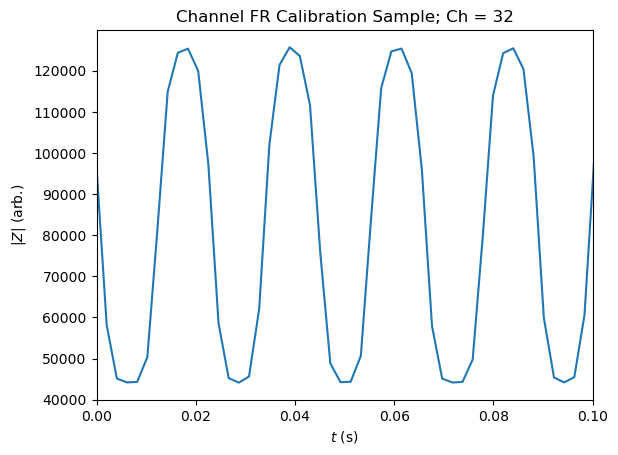

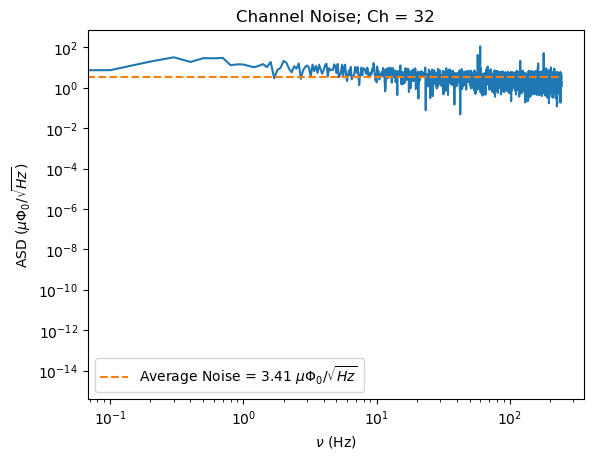

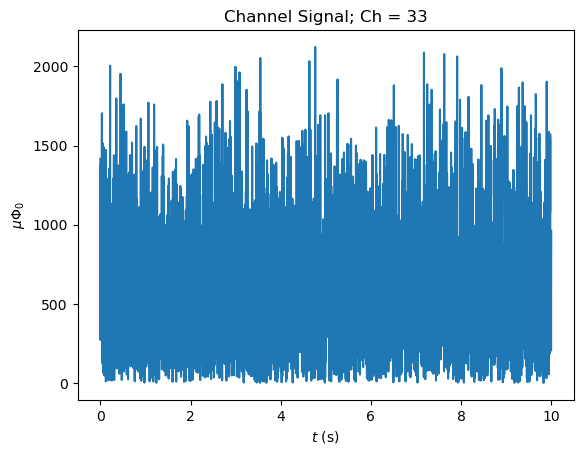

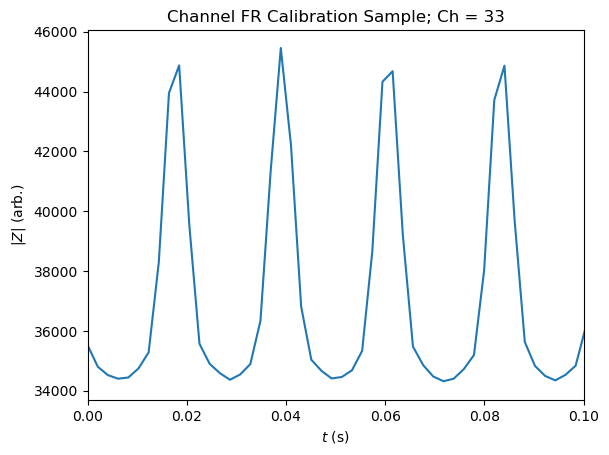

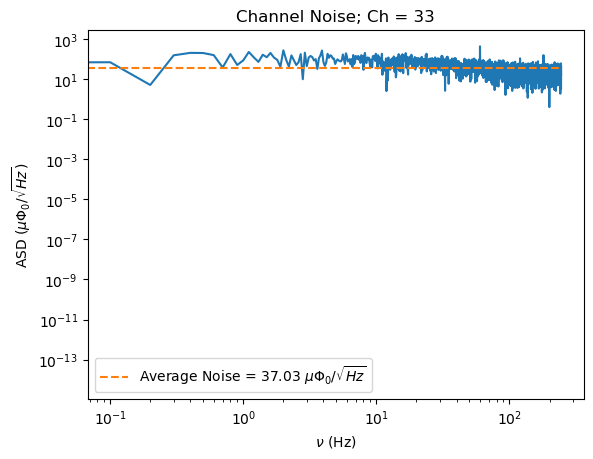

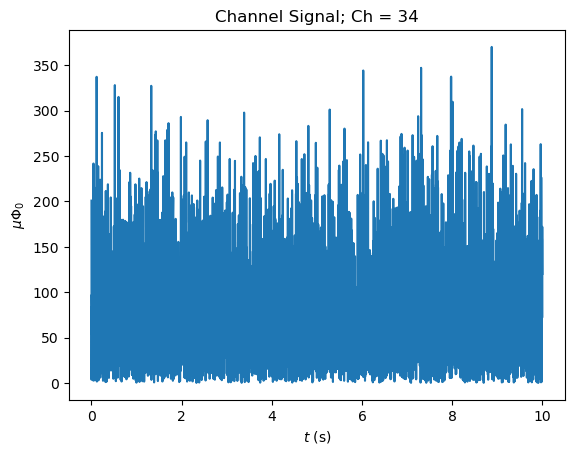

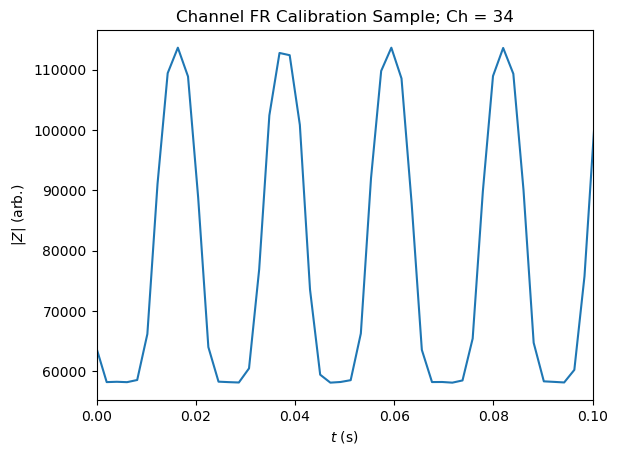

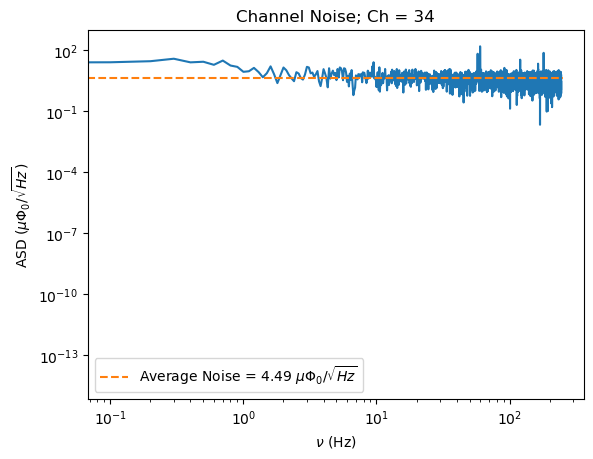

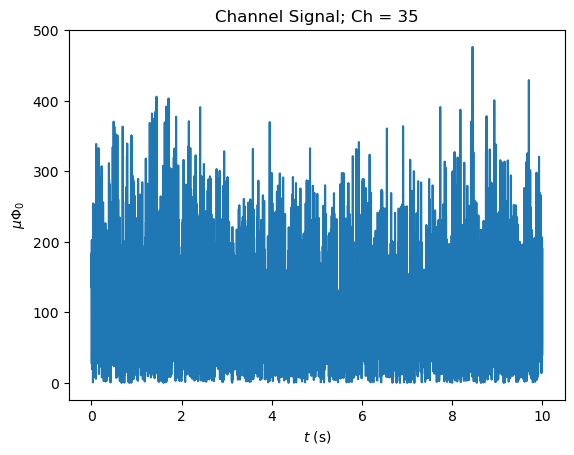

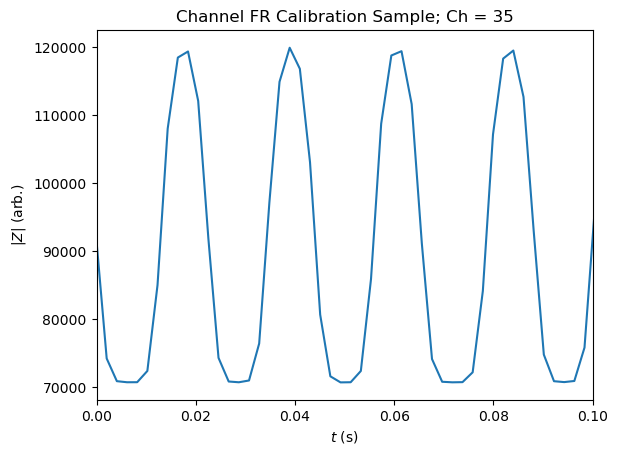

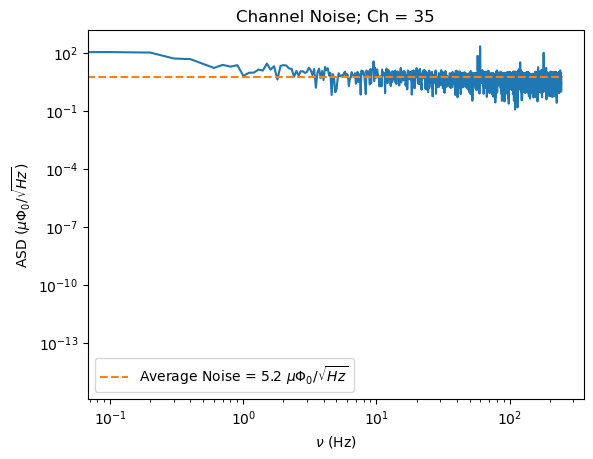

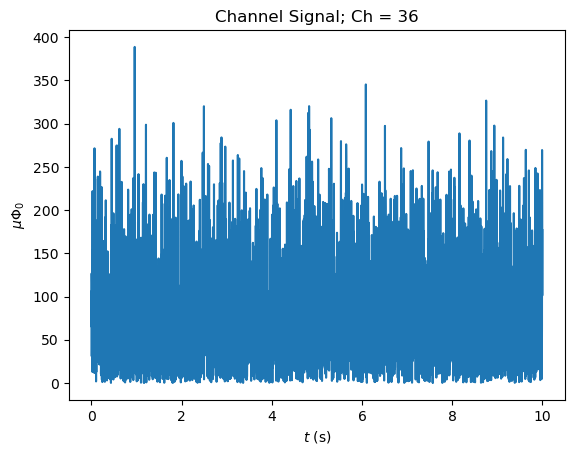

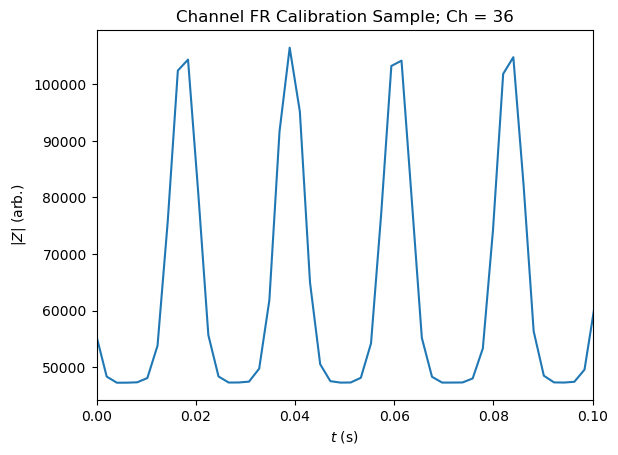

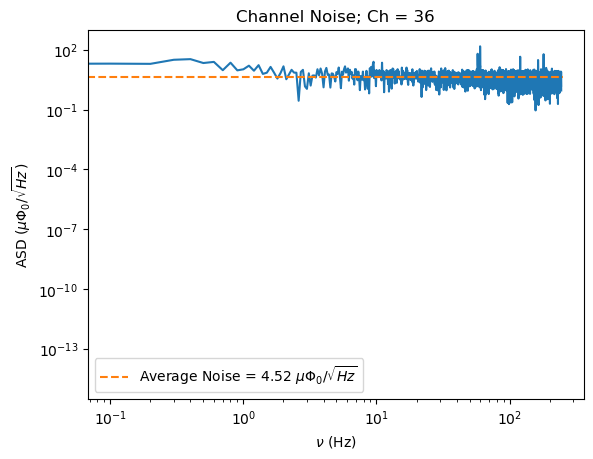

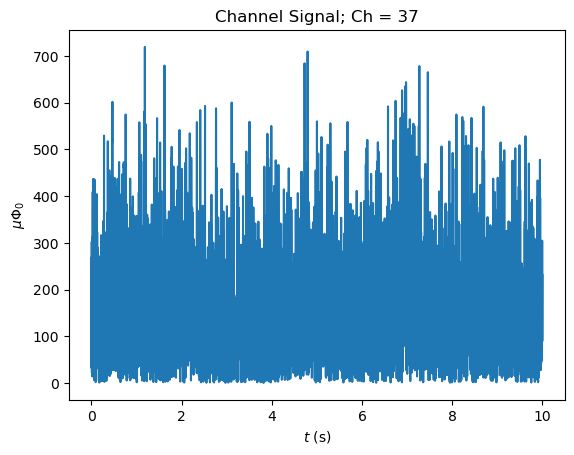

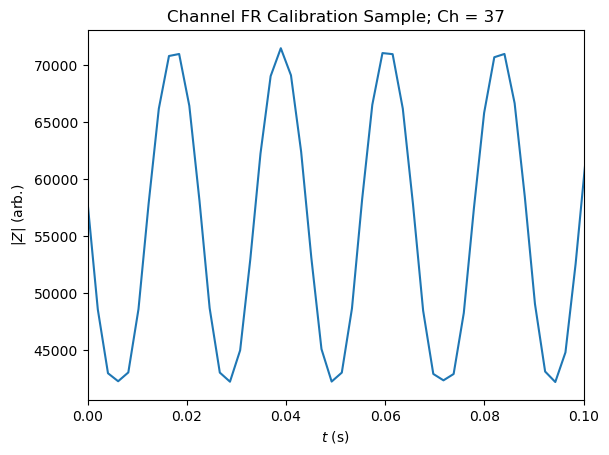

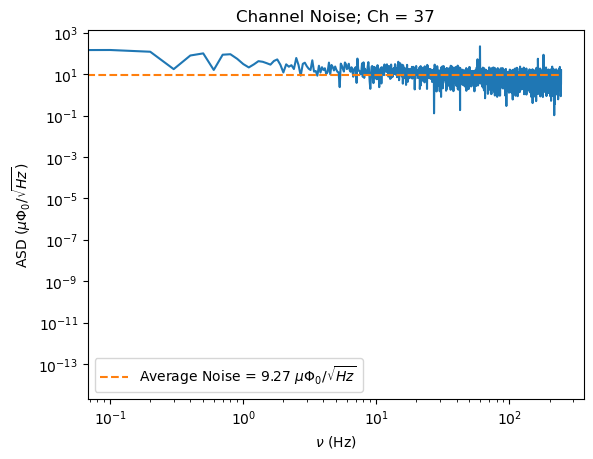

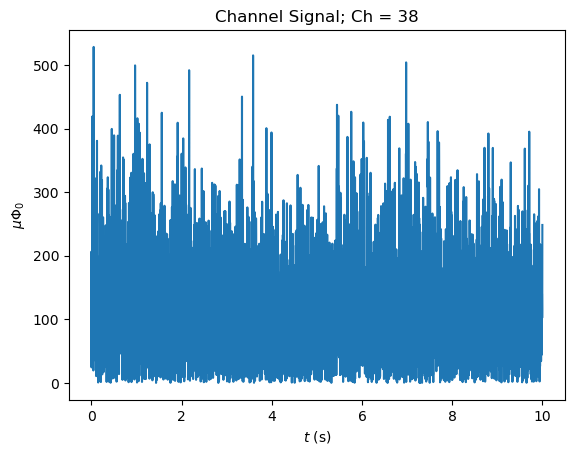

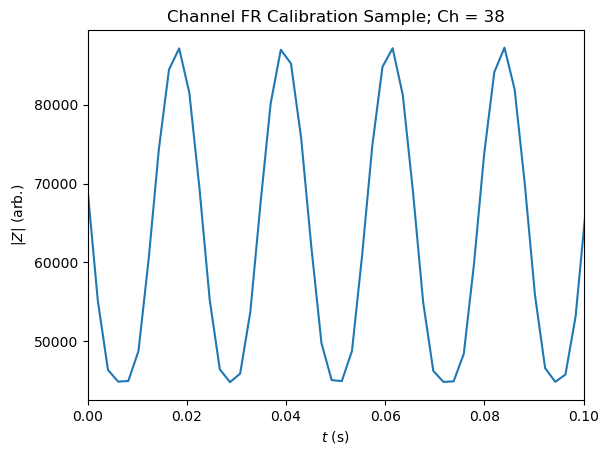

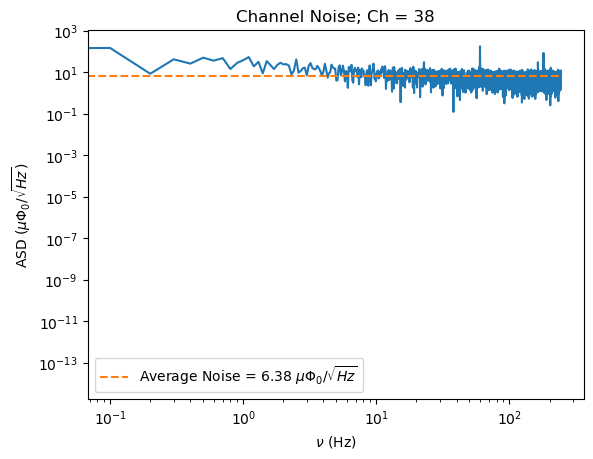

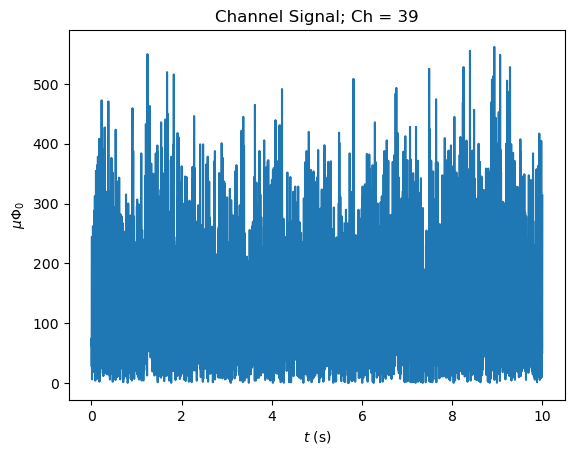

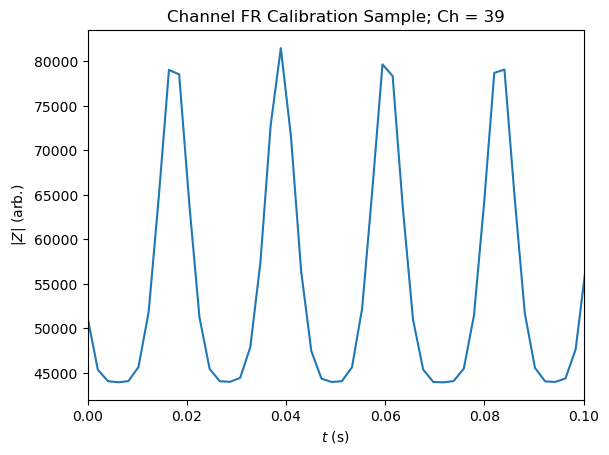

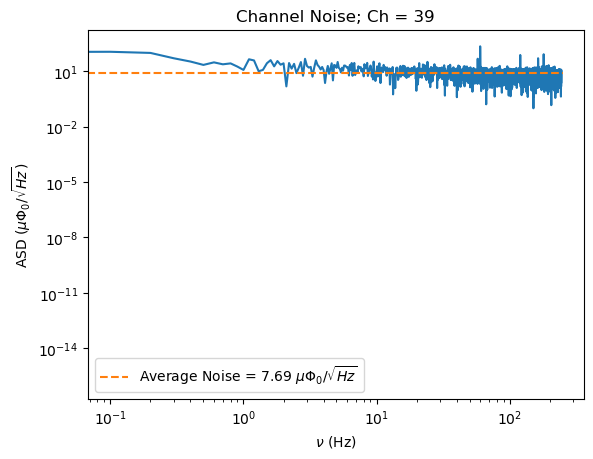

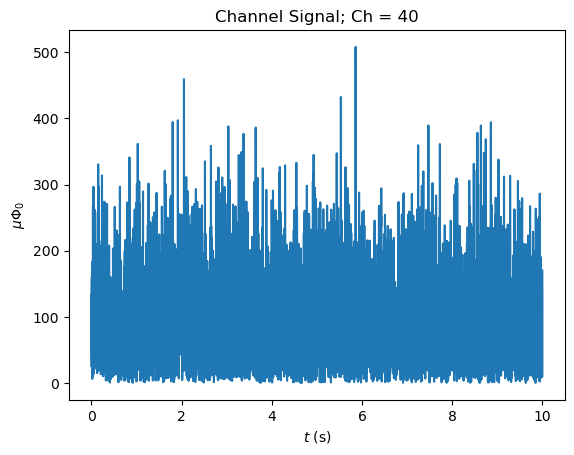

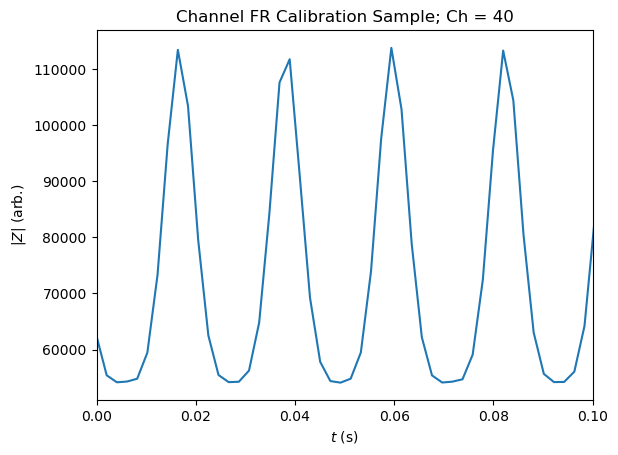

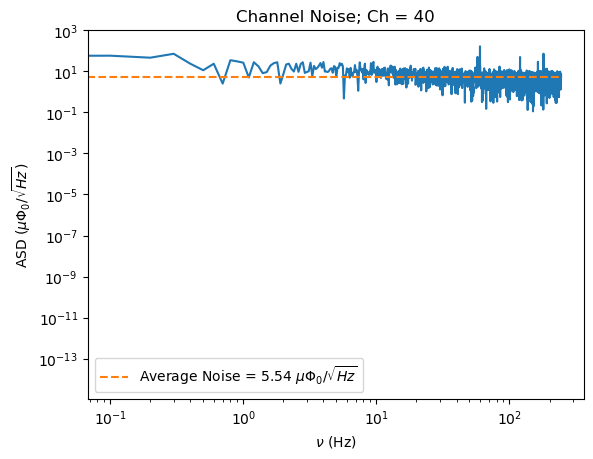

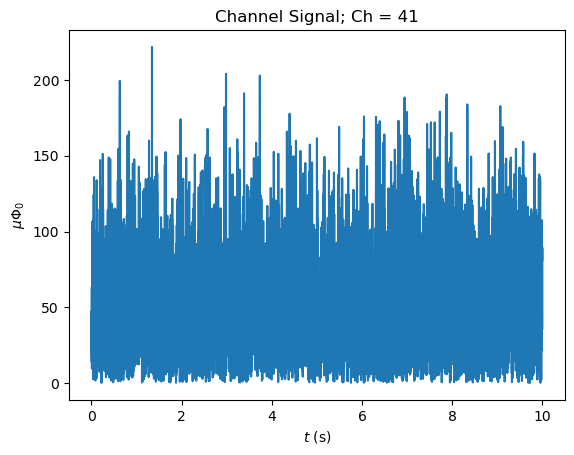

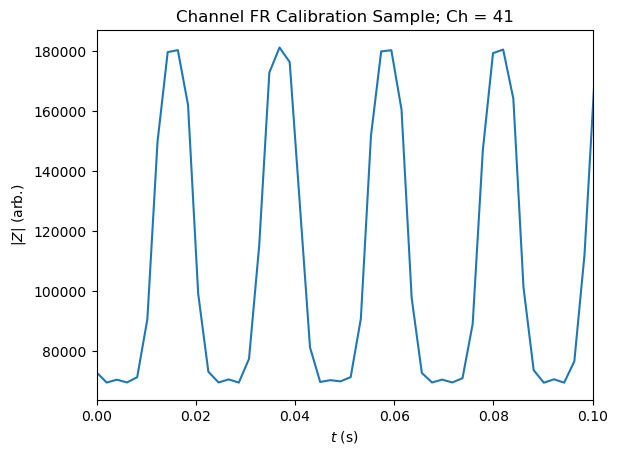

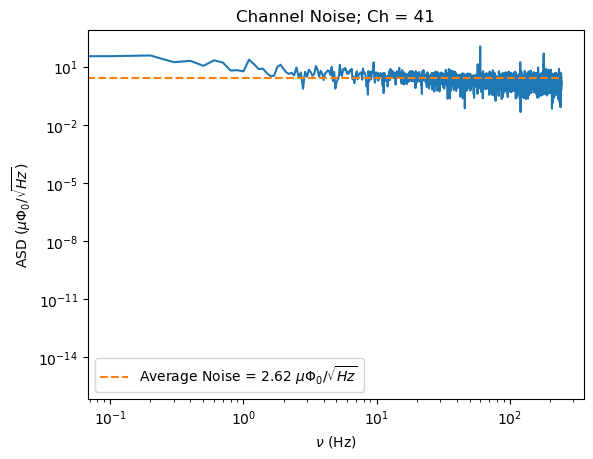

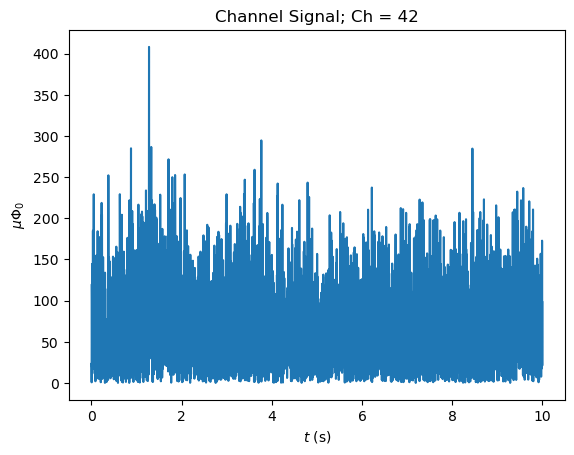

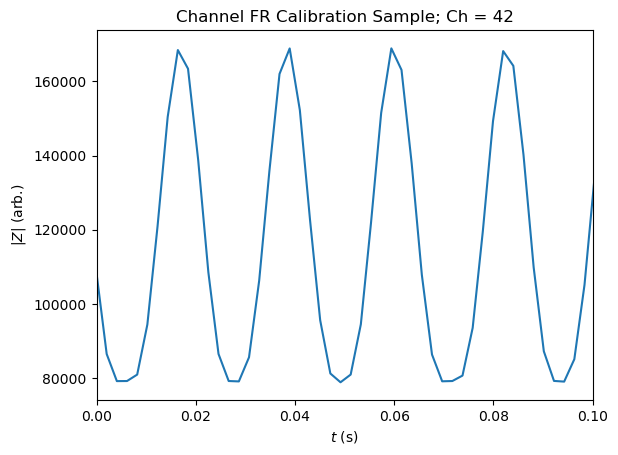

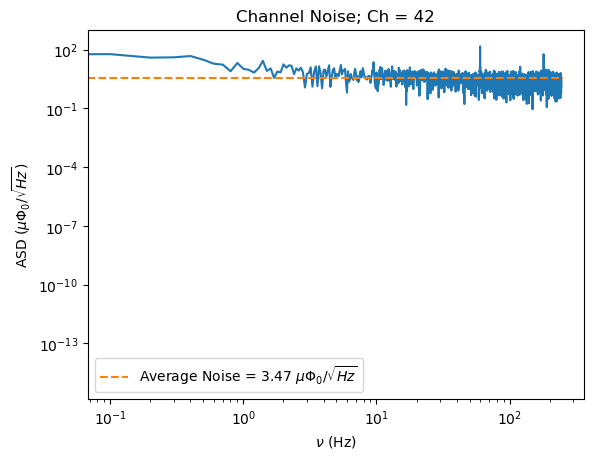

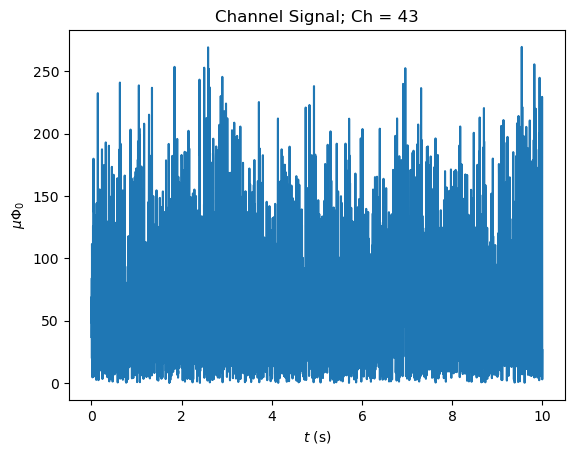

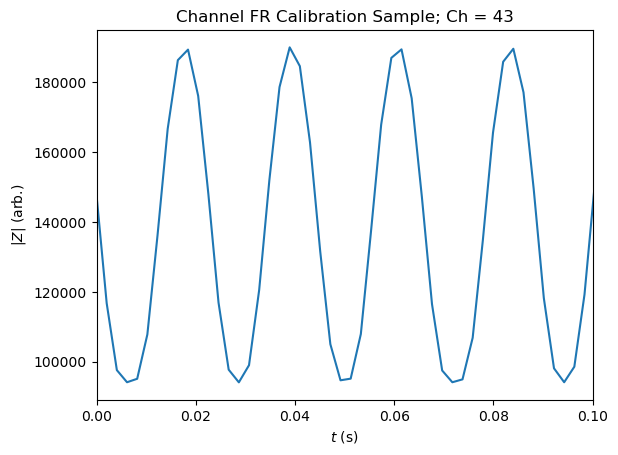

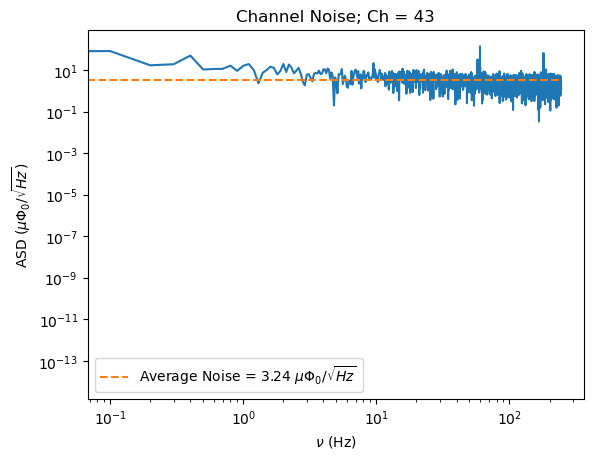

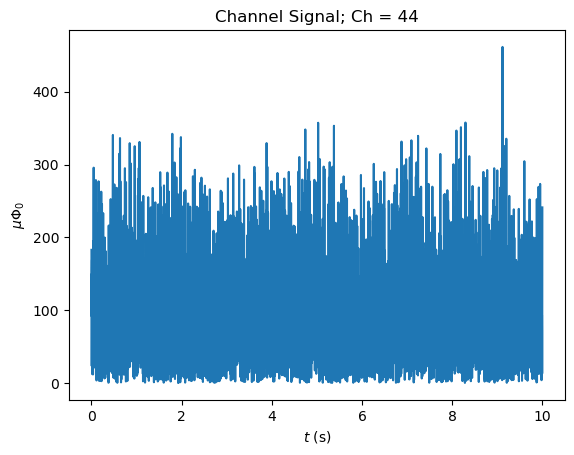

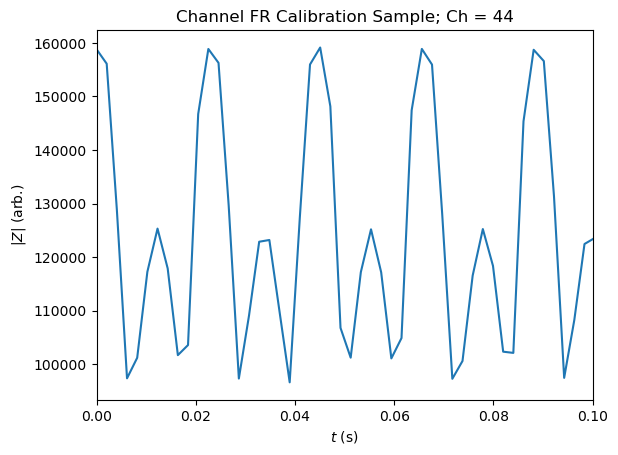

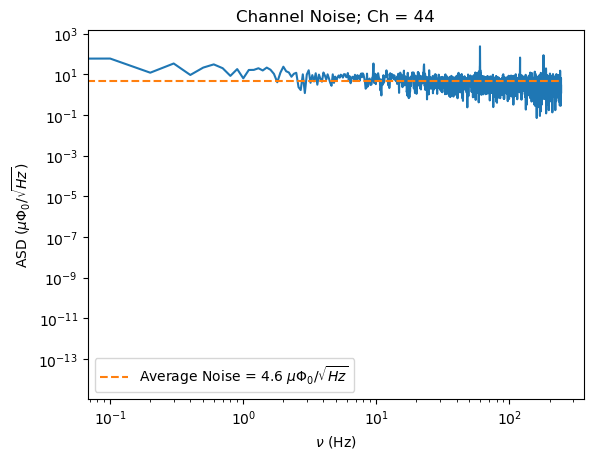

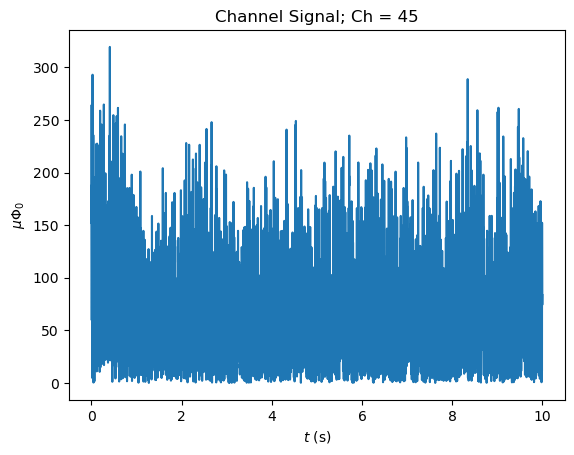

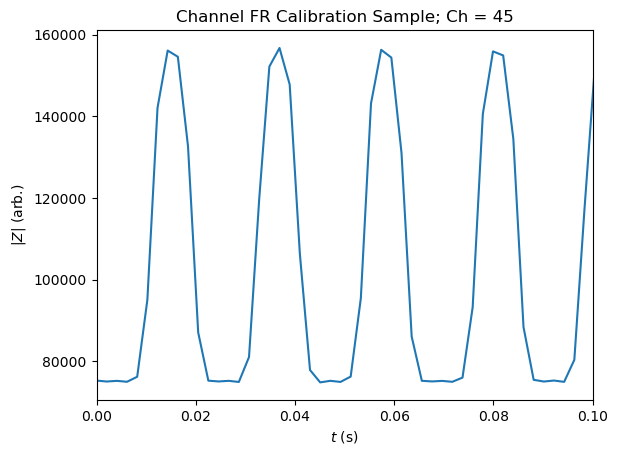

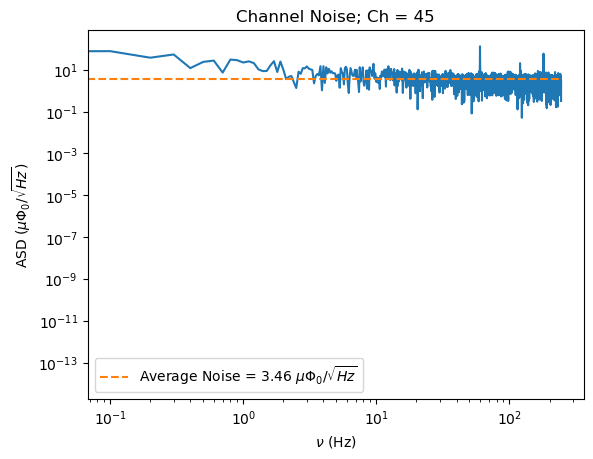

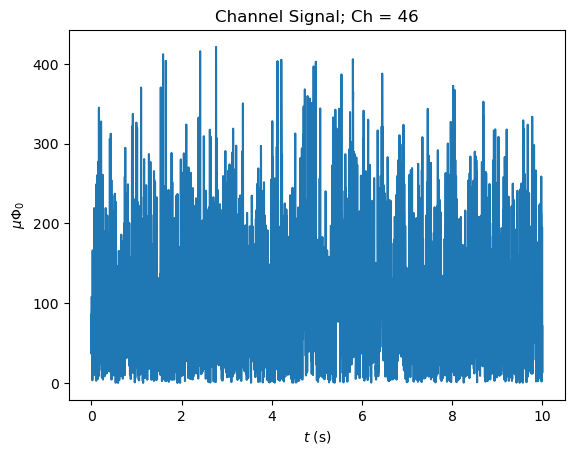

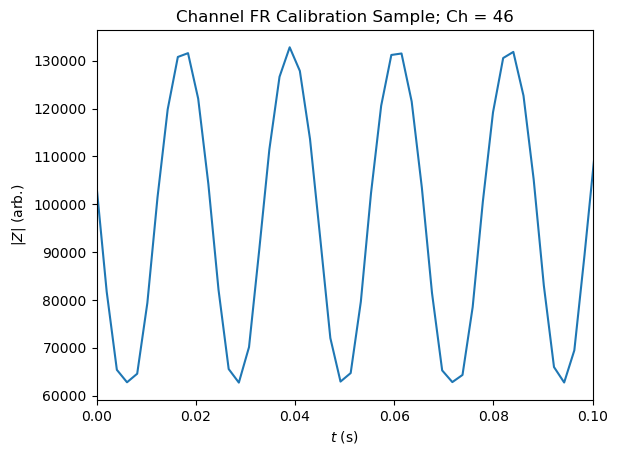

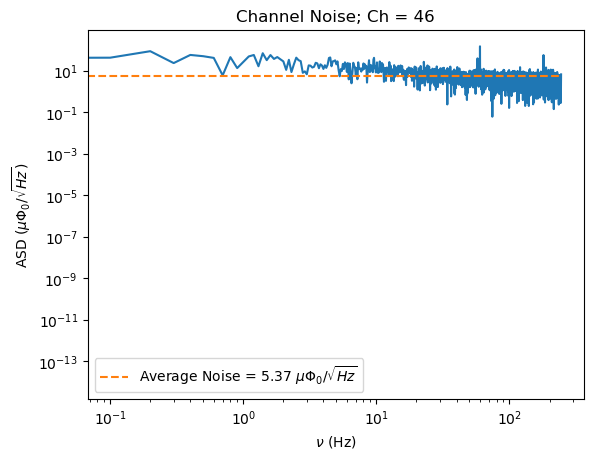

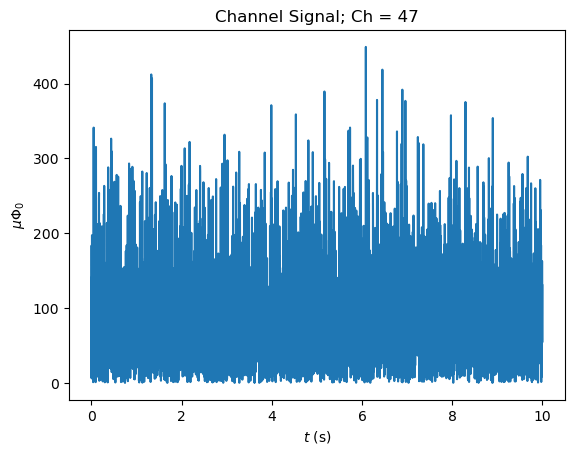

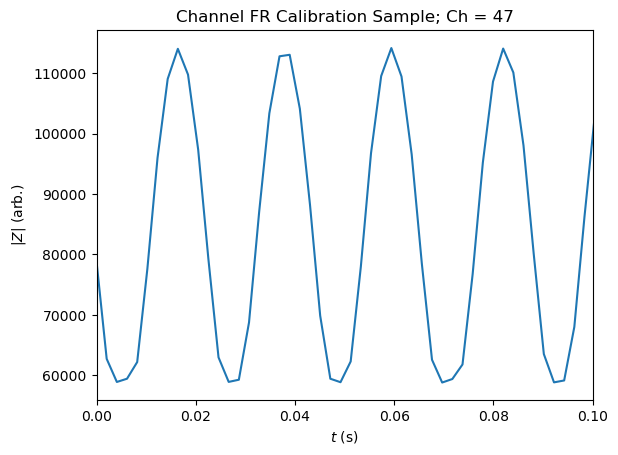

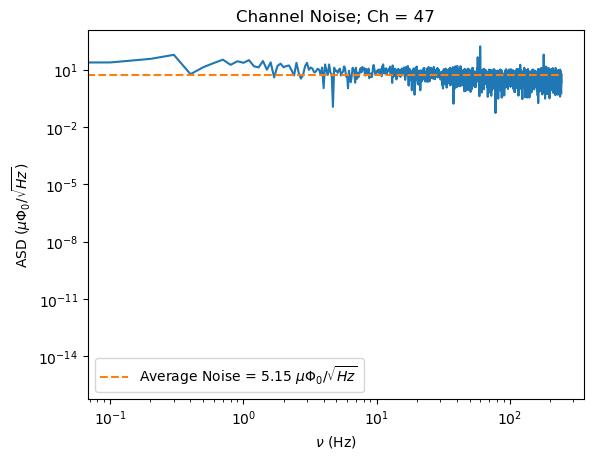

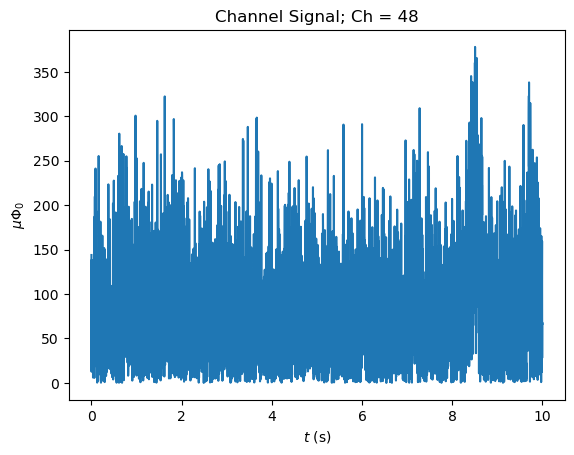

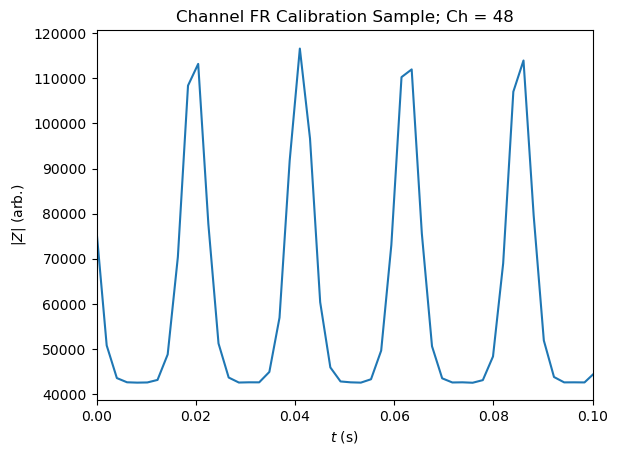

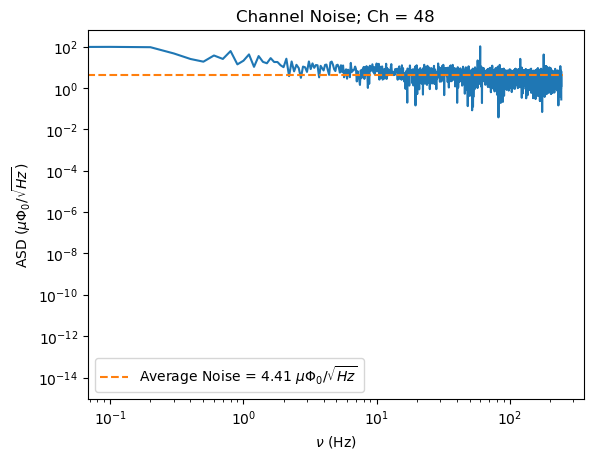

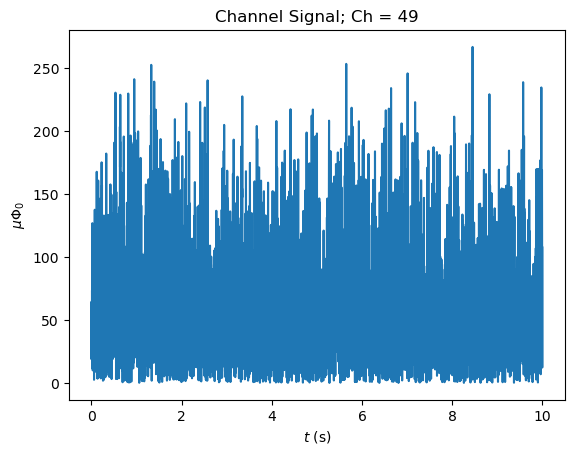

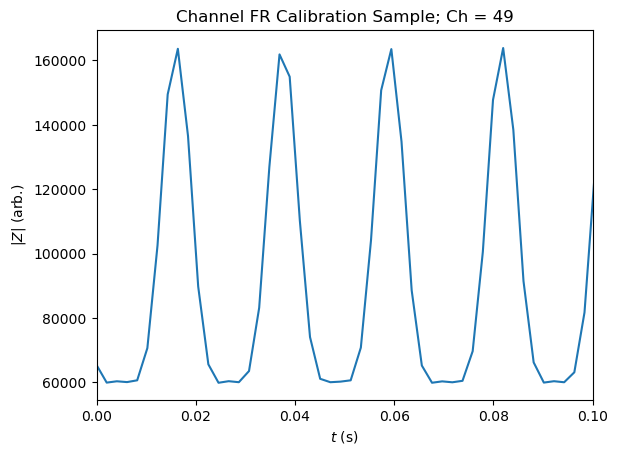

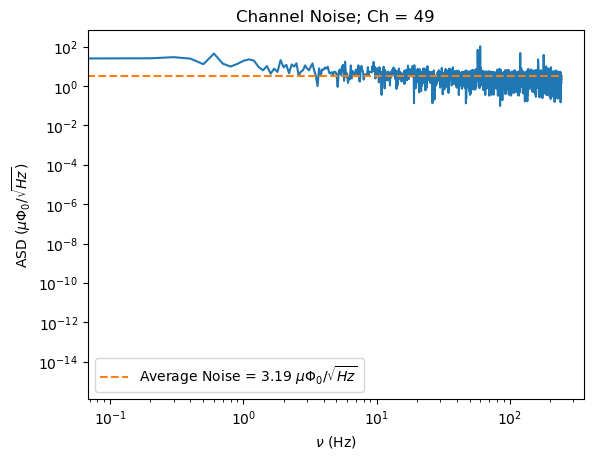

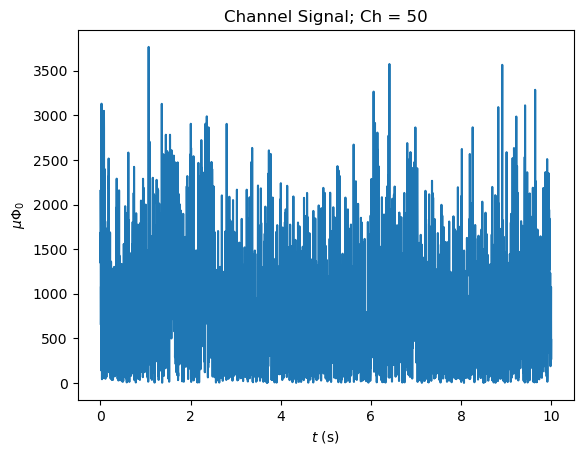

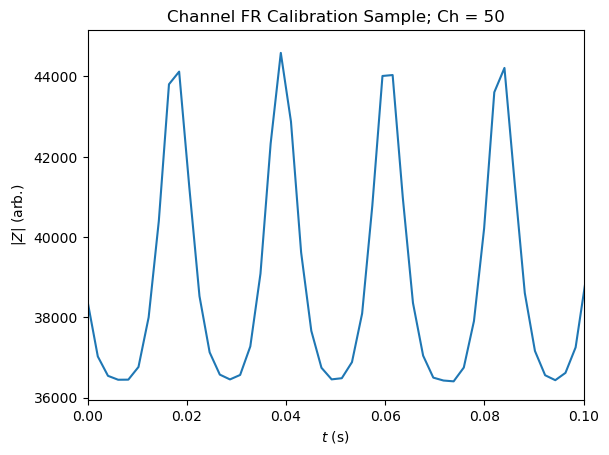

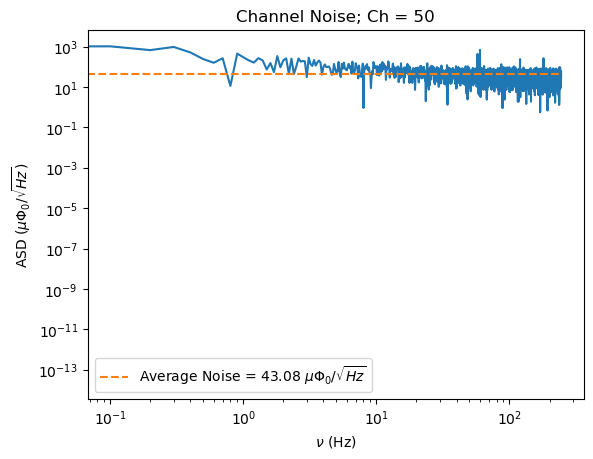

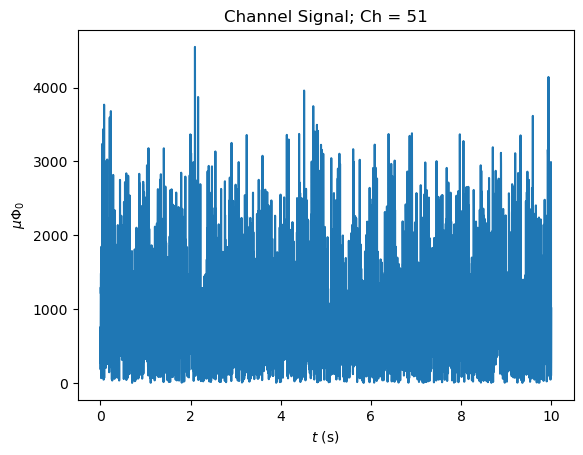

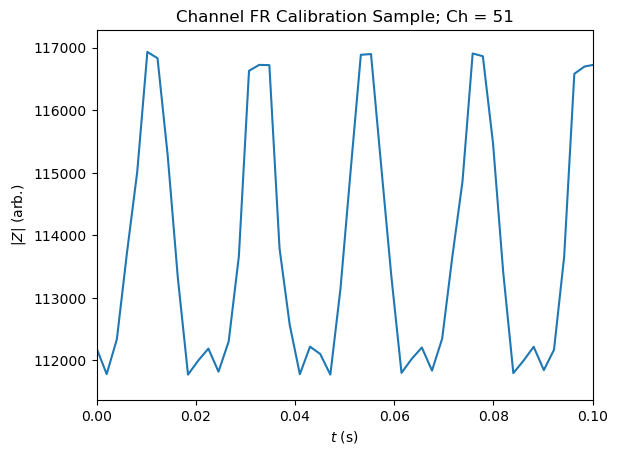

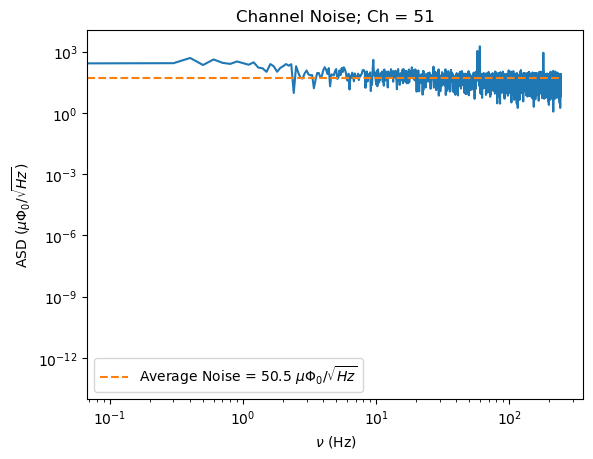

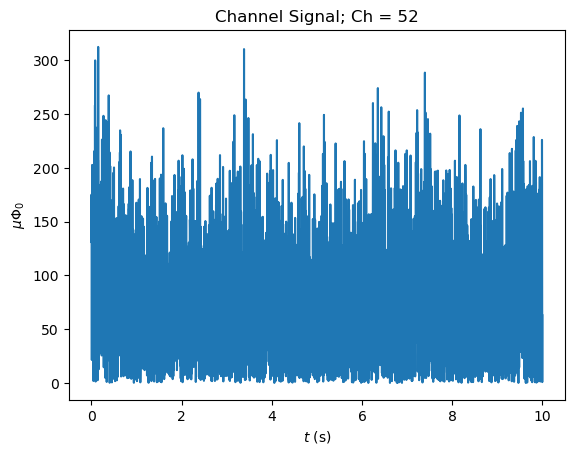

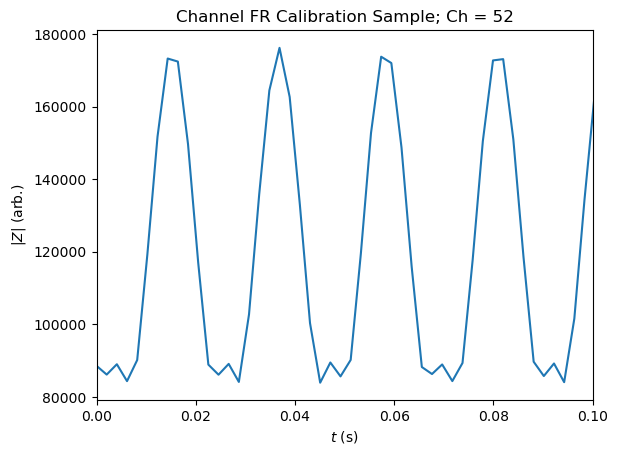

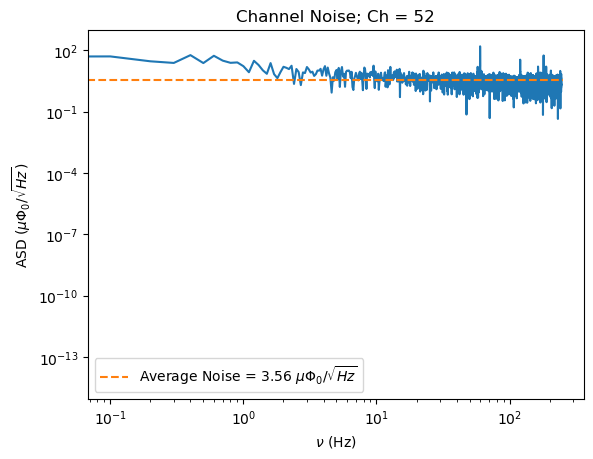

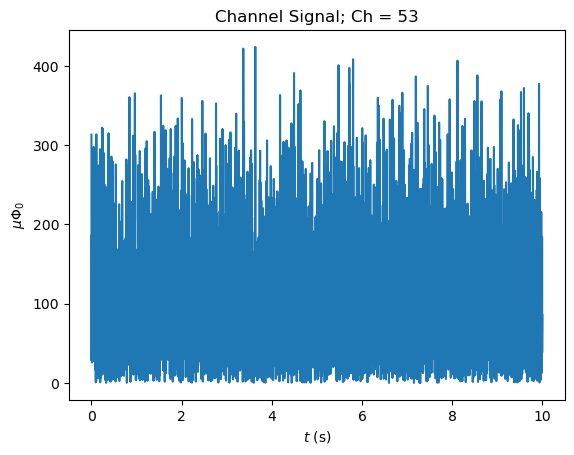

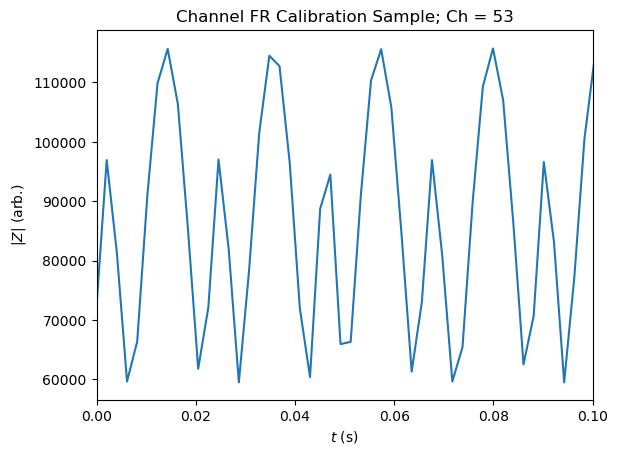

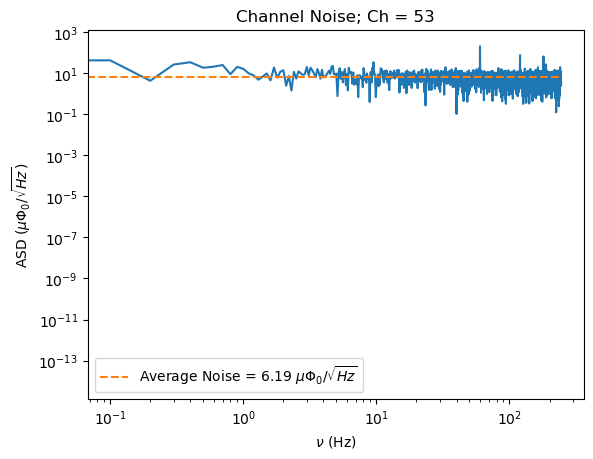

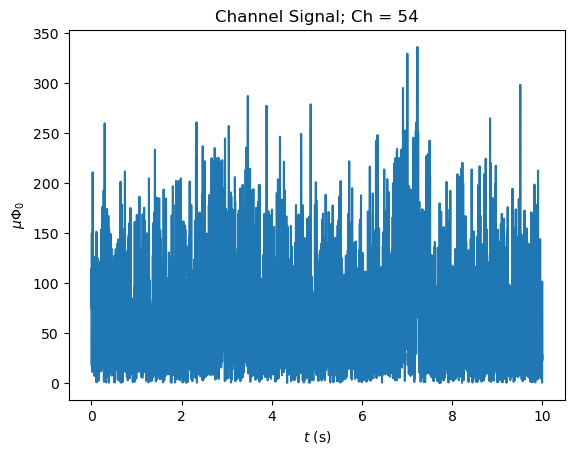

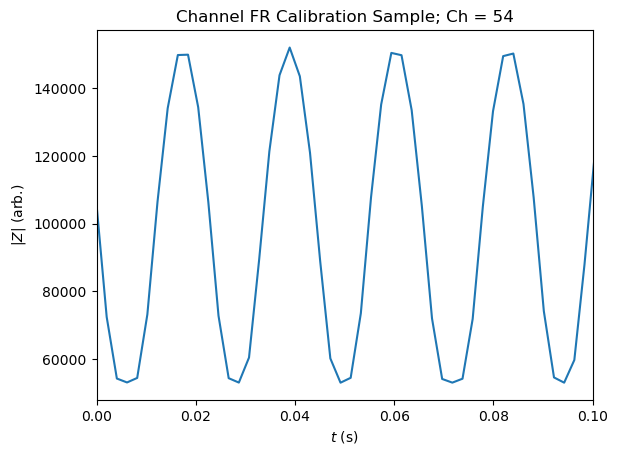

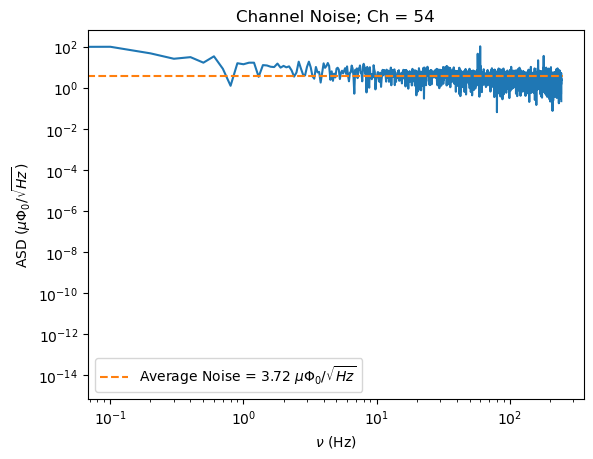

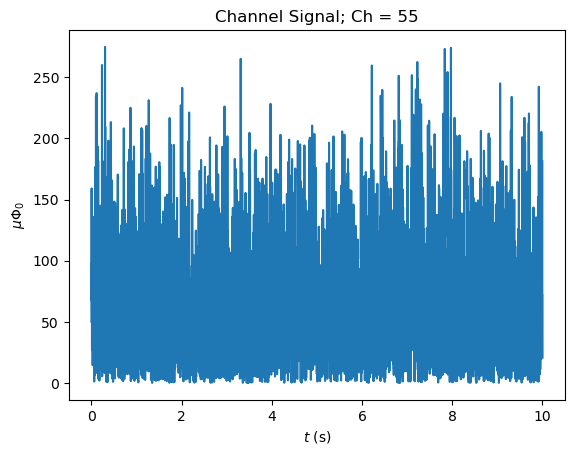

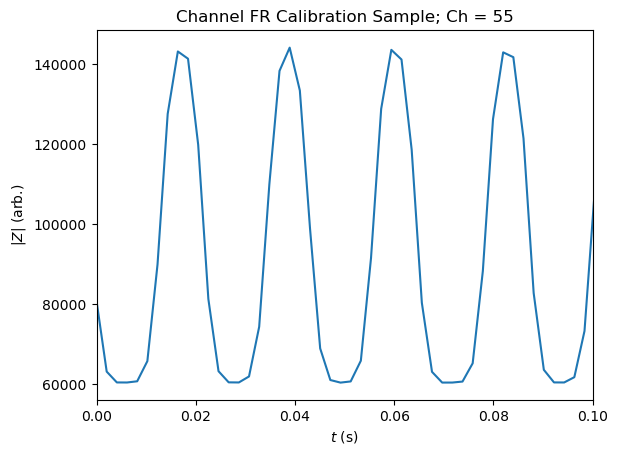

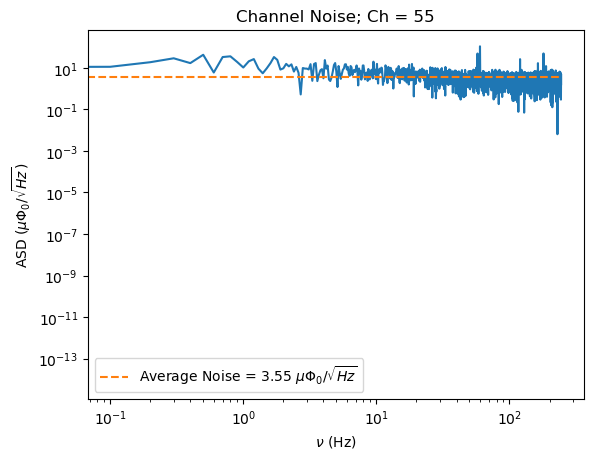

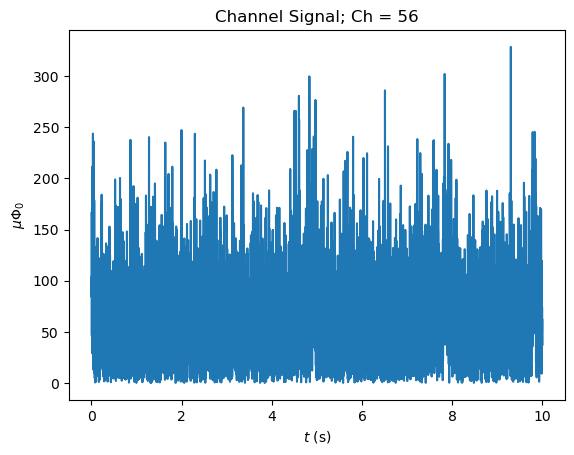

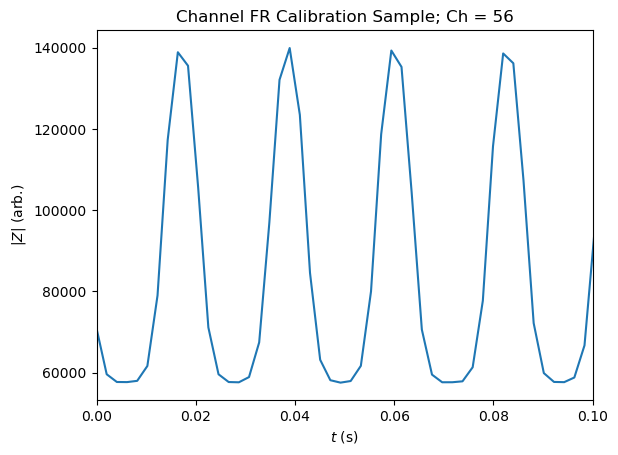

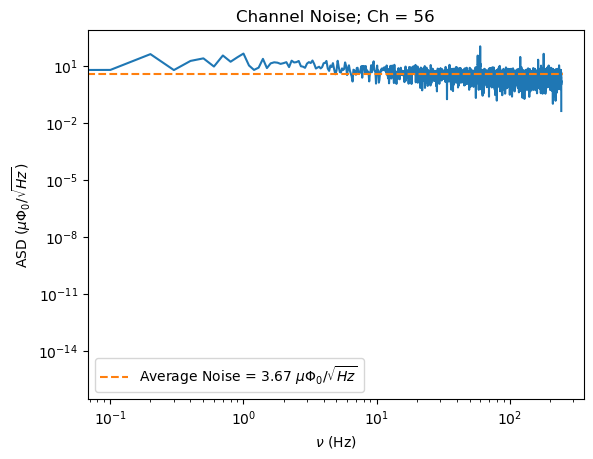

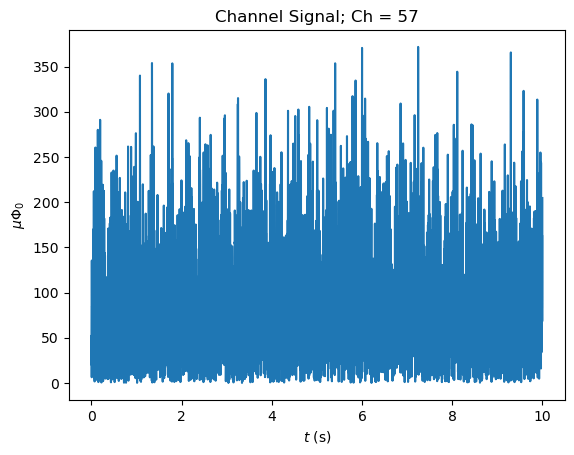

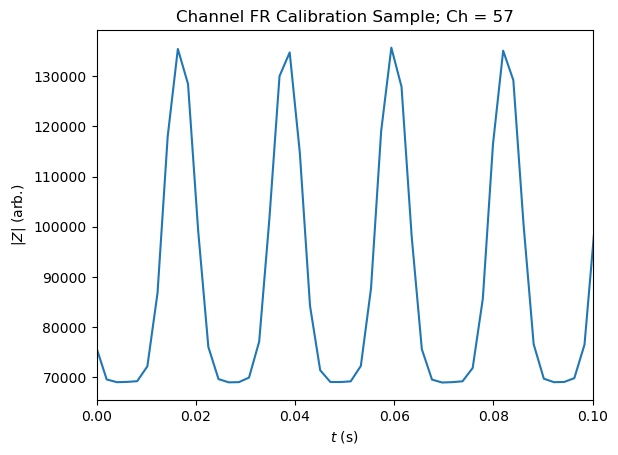

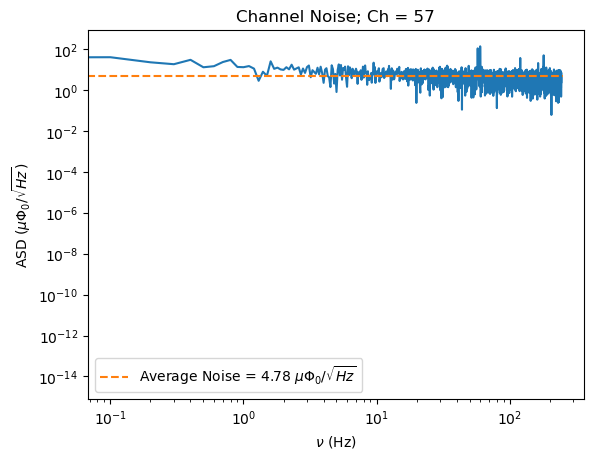

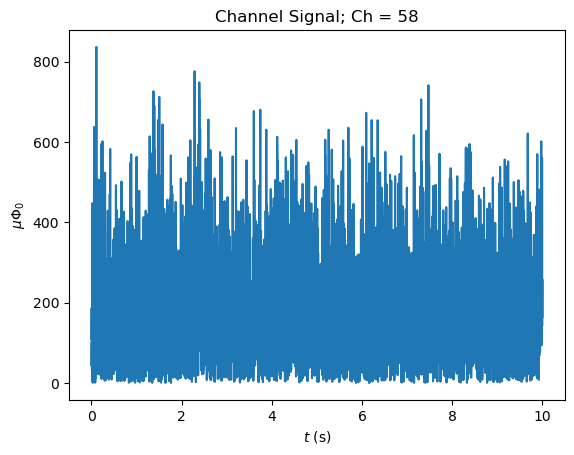

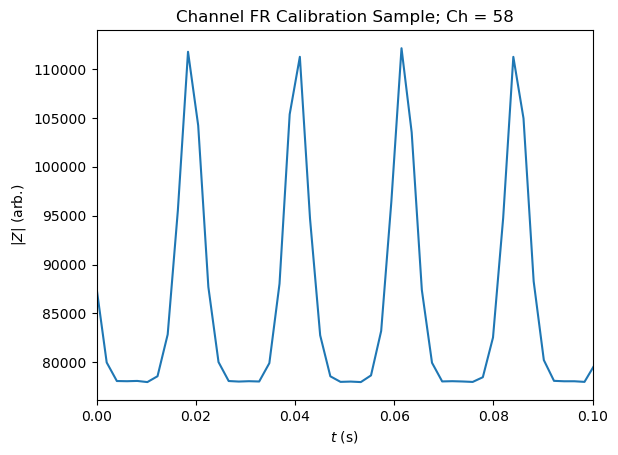

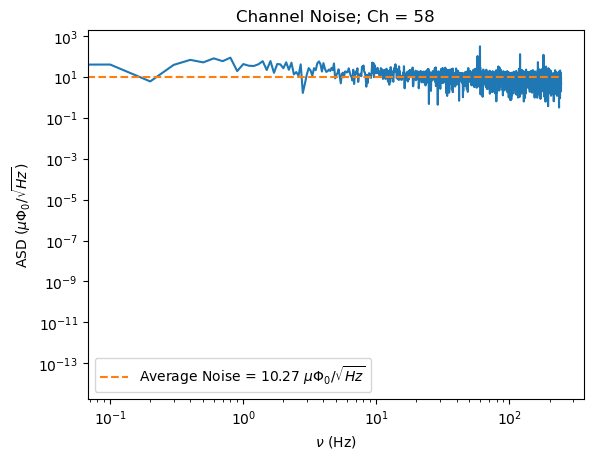

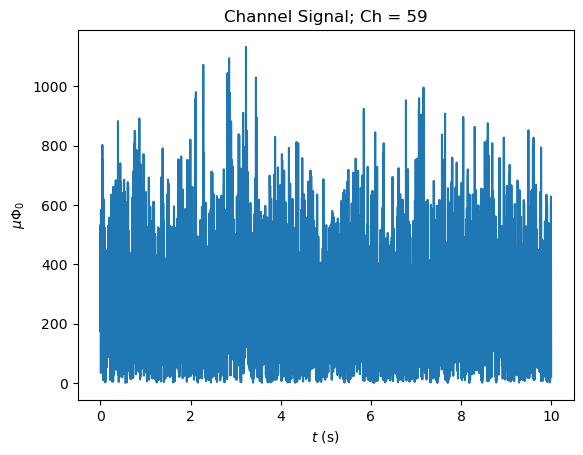

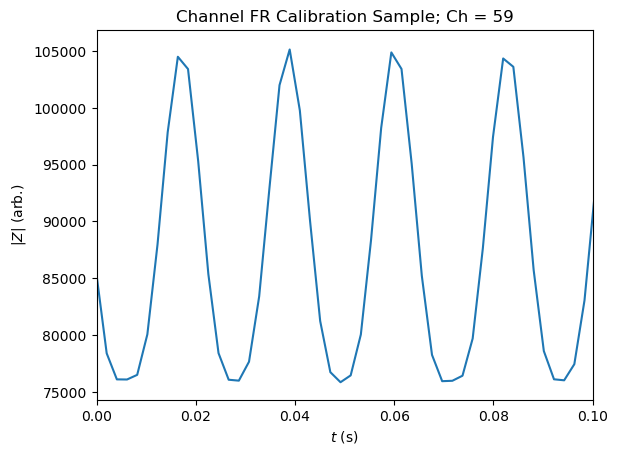

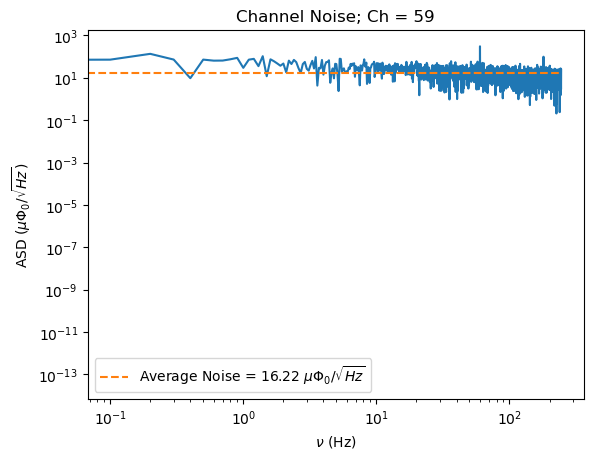

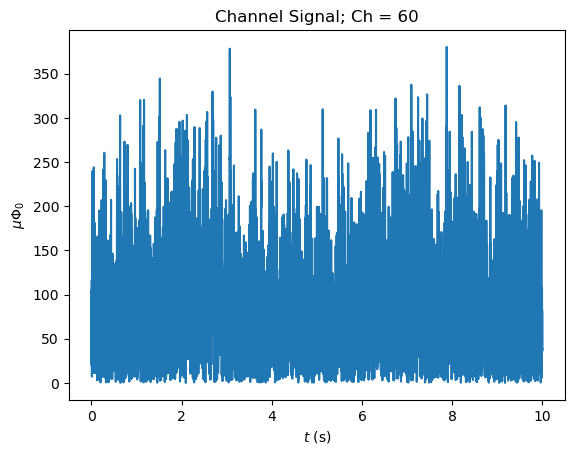

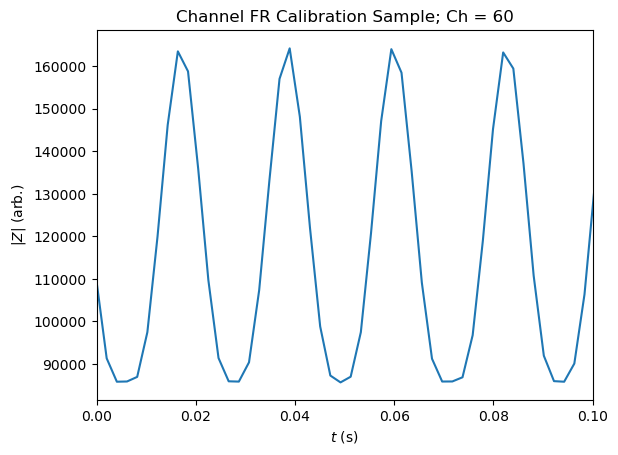

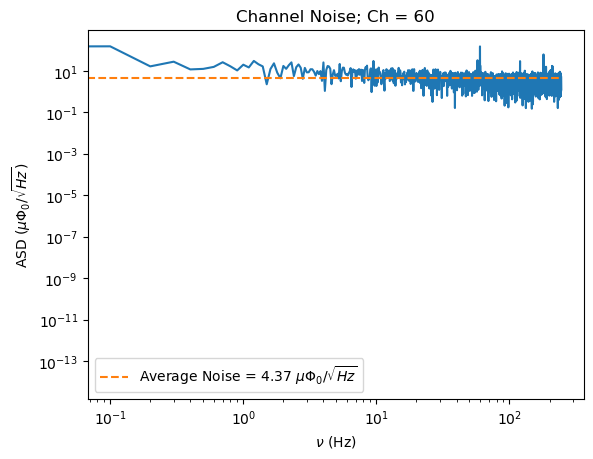

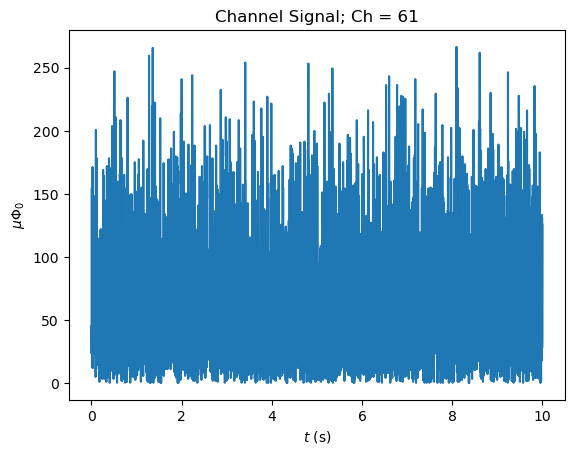

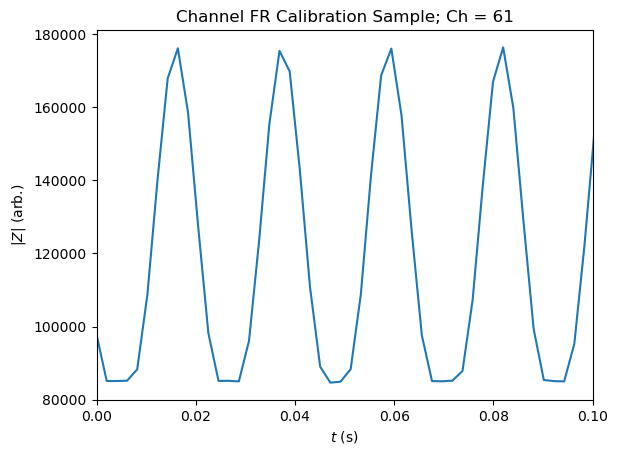

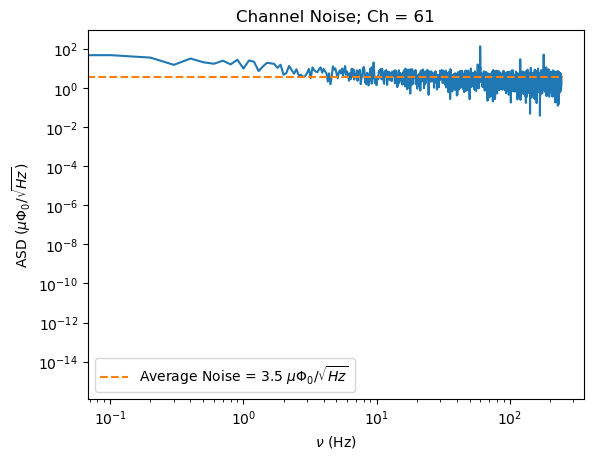

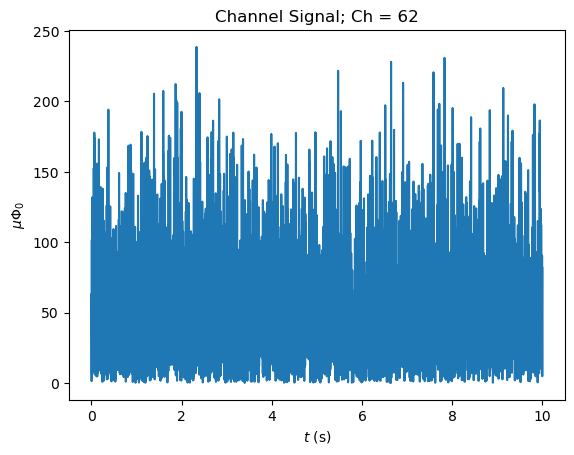

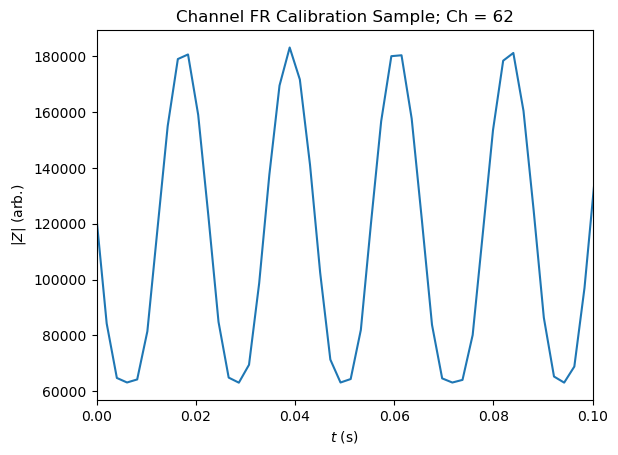

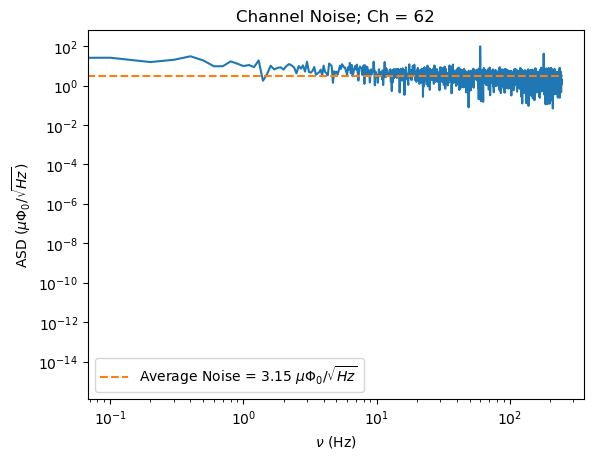

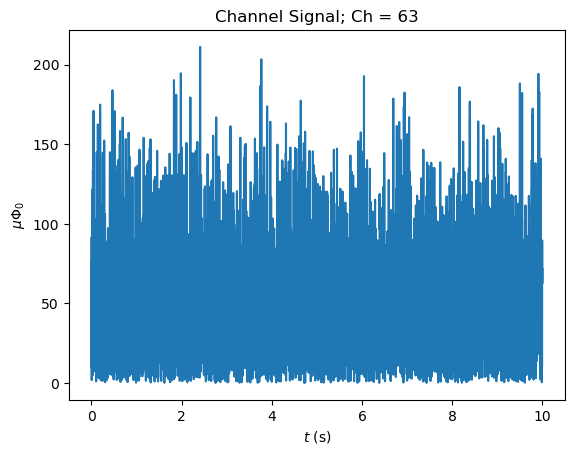

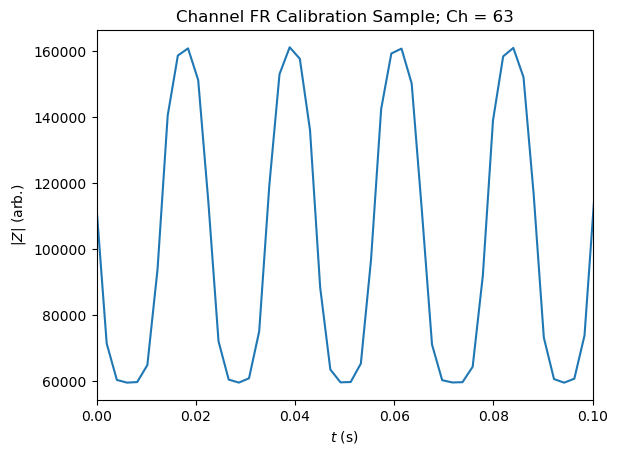

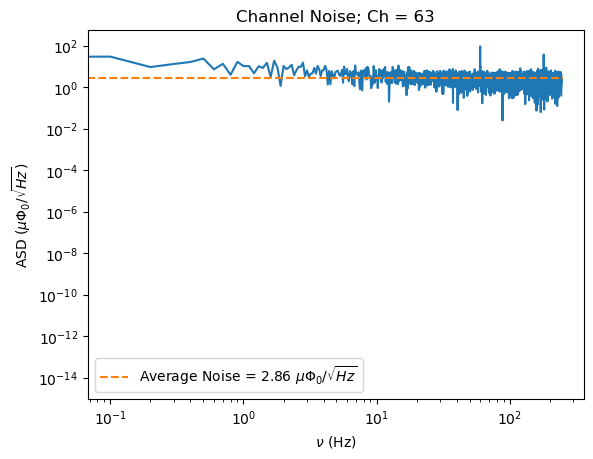

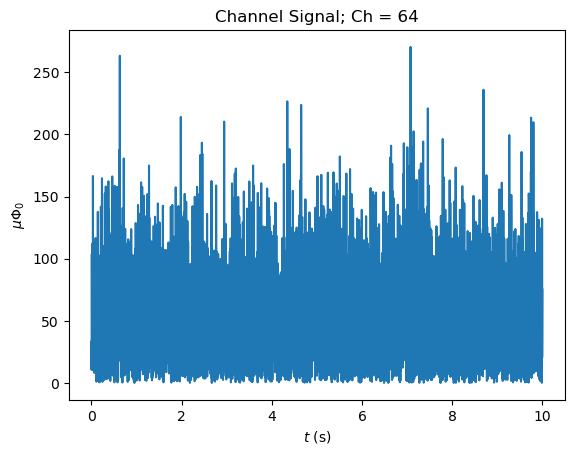

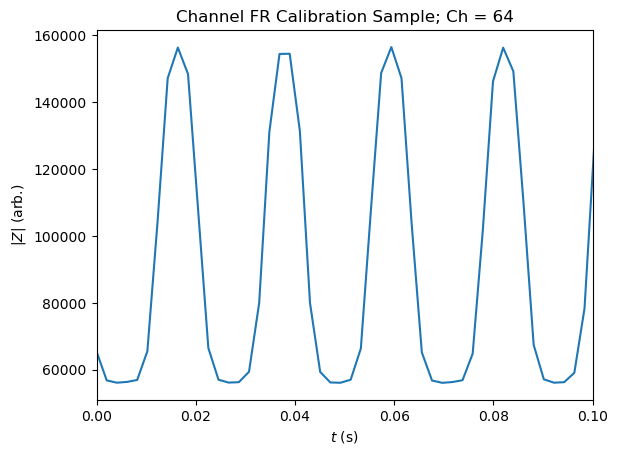

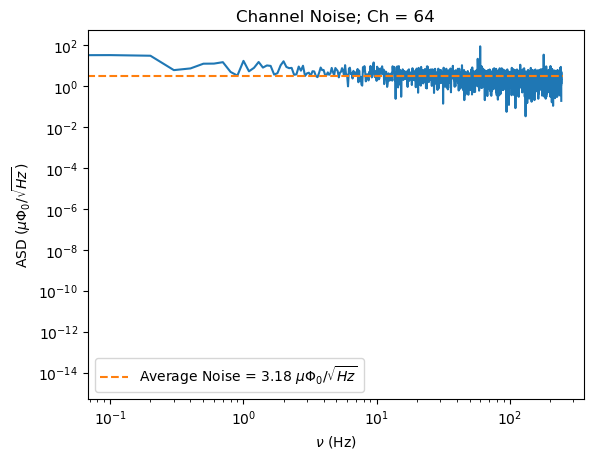

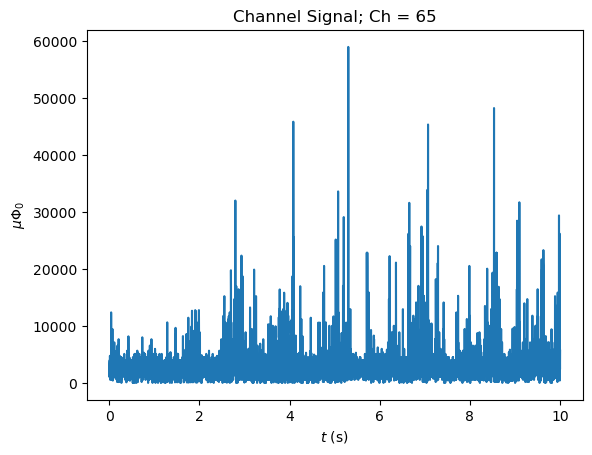

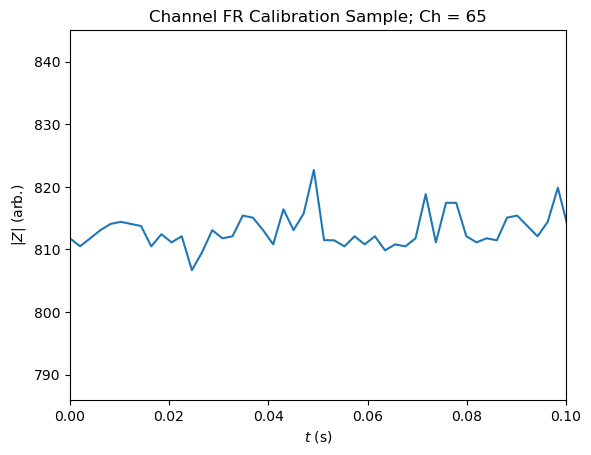

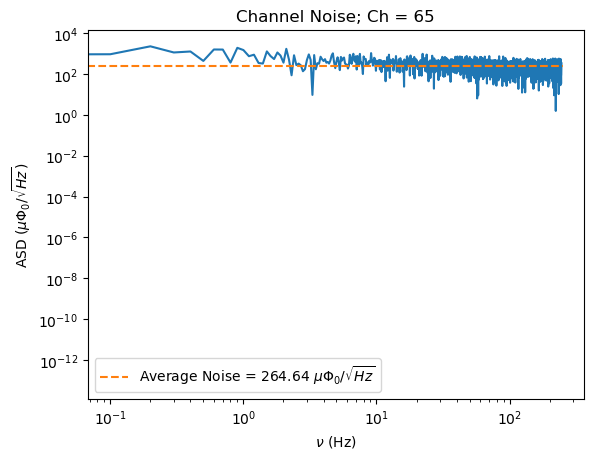

In [464]:
%matplotlib inline

fs = 256e6/(1*(2**19)-1)

#amplitude calibration file (15 Hz open loop)
amplitude_cal_file = f'{datapath}\\time_streams\\ts_toneinit_fcenter_5050.0_20250205125710_t_20250205130210.hd5'
amplitude_cal_t, amplitude_cal_I, amplitude_cal_Q = rotate_ts_IQ(datafile = amplitude_cal_file)
amplitude_cal_Z = amplitude_cal_I + 1j*amplitude_cal_Q

#Z = Z - np.average(Z)


t_override = np.linspace(0,10,len(amplitude_cal_I[0]))



A = np.max(np.abs(amplitude_cal_Z),axis=1) - np.min(np.abs(amplitude_cal_Z), axis=1)#50000#(np.max(np.abs(Z)) - np.min(np.abs(Z)))
Z_scaled = (np.abs(Z) - np.mean(np.abs(Z),axis=1)[:,np.newaxis]) / A[:,np.newaxis] * 1e6  / (2*np.pi) #A[:,np.newaxis(len(Z))]

f, Pxx_den = periodogram(Z_scaled, fs)

ASD = np.sqrt(Pxx_den)
ASD_averaged = np.mean(ASD, axis = 1)
ASD_stdev = np.std(ASD, axis = 1)



for i in tqdm(range(66)):
    if i < 10:
        print(f'Ch {i} Noise                        = {ASD_averaged[i]:.2f} +/- {ASD_stdev[i]:.2f} μΦ_0/sqrt(Hz)')
    elif i >= 10 and i < 100:
        print(f'Ch {i} Noise                       = {ASD_averaged[i]:.2f} +/- {ASD_stdev[i]:.2f} μΦ_0/sqrt(Hz)')
    elif i >= 100 and i < 1000:
        print(f'Ch {i} Noise                      = {ASD_averaged[i]:.2f} +/- {ASD_stdev[i]:.2f} μΦ_0/sqrt(Hz)')
    else:
        print(f'Ch {i} Noise                     = {ASD_averaged[i]:.2f} +/- {ASD_stdev[i]:.2f} μΦ_0/sqrt(Hz)')

    fig, ax = plt.subplots(1)
    fig2, ax2 = plt.subplots(1)
    fig3, ax3 = plt.subplots(1)
    
    ax.plot(t_override, np.abs(Z_scaled[i]))
    ax.set_xlabel('$t$ (s)')
    ax.set_ylabel('$\\mu \\Phi_0$')
    ax.set_title(f'Channel Signal; Ch = {i}')
    #ax.set_ylim([-0.25,0.25])
    fig.savefig(f'./plots/Ch_{i}_demodulated_timestream.png',dpi = 300)
    
    ax2.plot(t_override, np.abs(amplitude_cal_Z[i]))
    ax2.set_xlim([0,0.1])
    ax2.set_xlabel('$t$ (s)')
    ax2.set_ylabel('$|Z|$ (arb.)')
    ax2.set_title(f'Channel FR Calibration Sample; Ch = {i}')
    fig2.savefig(f'./plots/Ch_{i}_FR_Sample.png',dpi = 300)
    
    
    ax3.loglog(f, ASD[i])
    ax3.hlines(ASD_averaged[i], 0, 250, color = 'tab:orange', linestyle = '--', label = 'Average Noise = ' + str(round(ASD_averaged[i],2)) + ' $\\mu \\Phi_0 / \\sqrt{Hz}$') #[:int(1*len(Pxx_den[21]))]
    ax3.set_xlabel('$\\nu$ (Hz)')
    ax3.set_ylabel('ASD ($\\mu \\Phi_0 / \\sqrt{Hz}$)')
    ax3.set_title(f'Channel Noise; Ch = {i}')
    ax3.legend()
    fig3.savefig(f'./plots/Ch_{i}_ASD.png',dpi = 300)

    


ASD_averaged_across_channels = np.mean(ASD_averaged[0:64])
ASD_stdev_across_channels = np.std(ASD_averaged[0:64])
print(f'Average Noise Across Channels     = {ASD_averaged_across_channels:.2f} +/- {ASD_stdev_across_channels:.2f} μΦ_0/sqrt(Hz)')
#print(f'A(20) = {A[20]}')

output_df = pd.DataFrame({'Channel': np.arange(0,len(ASD),1), 'Noise (microPhi0 / sqrt(Hz))': ASD_averaged, 'Standard Deviation (microPhi0 / sqrt(Hz))': ASD_stdev})
output_df.to_csv('./plots/Noise_Summary.csv')



4.49722659031154


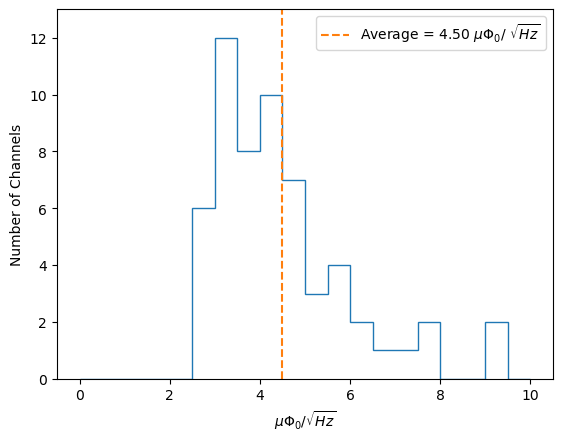

In [528]:
fig, ax = plt.subplots(1)

ax.hist(ASD_averaged, bins=20, range = [0,10], histtype = 'step', color = 'tab:blue')

average = ASD_averaged[ASD_averaged <10].mean() #np.average(ASD_averaged, weights=ASD_averaged<10)
print(average)

Hz = 'Hz'

ax.vlines(average,0,14,linestyle = '--',color = 'tab:orange', label = f'Average = {average:.2f} $\\mu \\Phi_0 $/ '+'$\\sqrt{Hz}$')

ax.legend()
ax.set_ylim([0,13])
ax.set_ylabel('Number of Channels')
ax.set_xlabel('$\\mu \\Phi_0 / \\sqrt{Hz}$')
fig.savefig(f'./plots/Noise_Summary.png',dpi = 300)

(1002, 4880)
(1002,)
(-37864.79981103366-18583.193909108017j)


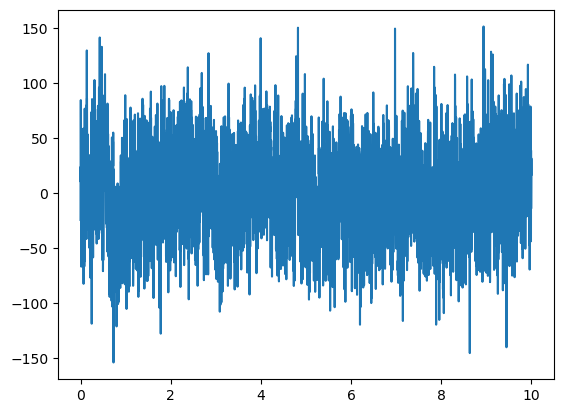

In [458]:
print(np.shape(Z_scaled))
print(np.shape(np.mean(Z_scaled,axis=1)))

fig, ax = plt.subplots(1)

ax.plot(t_override, np.abs(Z[0]) - np.average(np.abs(Z[0])))

print(np.average(Z[0]))

In [ ]:
# I and Q separately

fs = 256e6/(1*(2**19)-1)

A = #(np.max(np.abs(Z)) - np.min(np.abs(Z)))
Z_scaled = np.abs(Z) / A * 1e6  / (2*np.pi)

f, Pxx_den = periodogram(Z_scaled, fs)

ASD = np.sqrt(Pxx_den)
ASD_averaged = np.mean(ASD, axis = 1)
ASD_stdev = np.std(ASD, axis = 1)

In [360]:
ch_freq= np.load(f'{datapath}\\tone_initializations\\fcenter_5050.0_20250205125710\\freq_list_lo_sweep_targeted_1_fcenter_5050.0_20250205125837.npy')

print(ch_freq[20], ch_freq[21])

(4903756507.812548+0j) (4905419078.125044+0j)


488.282181324351